# Mutational Signatures to Gene Expression Regression Analysis

This notebook explores the relationship between mutational signatures and gene expression patterns across TCGA Pan-Cancer data.

## Overview
- Load and preprocess TCGA mutational signatures data
- Load and preprocess TCGA gene expression data
- Build regression models to predict gene expression from mutational signatures
- Evaluate model performance and biological significance

In [46]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import kaleido


# Set plotting style
sns.set_context('notebook')
%matplotlib inline

In [71]:
import os
sigs_dir_musical='/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/final_H'
matrices_paths = [x for x in os.listdir(sigs_dir_musical) if x.endswith('.csv')]
# Split the filenames in that directory by _, keep the first part and prepend it to the name of each column in each respective matrix
matrices = [pd.read_csv(os.path.join(sigs_dir_musical, m), index_col=0) for m in matrices_paths]
prefixes = [m.split('_')[0] for m in matrices_paths]
for i, m in enumerate(matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Merge the matrices, but take into account the different columns
merged_matrix_musical = pd.concat(matrices, axis=0)

In [72]:
[x.shape for x in matrices]

[(307, 17), (551, 19), (1072, 24), (486, 23)]

In [73]:
merged_matrix_musical.shape

(2416, 28)

In [75]:
np.unique(merged_matrix_musical.columns,return_counts=True)

(array(['SBS1', 'SBS100', 'SBS10a', 'SBS10b', 'SBS10d', 'SBS13', 'SBS14',
        'SBS15', 'SBS17a', 'SBS18', 'SBS2', 'SBS20', 'SBS21', 'SBS26',
        'SBS28', 'SBS3', 'SBS31', 'SBS34', 'SBS35', 'SBS36', 'SBS5',
        'SBS51', 'SBS54', 'SBS60', 'SBS8', 'SBS96', 'SBS97', 'SBS98'],
       dtype=object),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))

In [76]:
# Load the gene expression data

expr_dir = '/gpfs/data/courses/aio2025/yb2612/data/c6_top1000'
expr_files = [x for x in os.listdir(expr_dir) if x.endswith('.csv')]
# Remove the file if it contains pangyn
expr_files = [x for x in expr_files if 'pangyn' not in x]
expr_matrices = [pd.read_csv(os.path.join(expr_dir, x), index_col=0) for x in expr_files]
expr_matrix = pd.concat(expr_matrices, axis=1)
prefixes = [x.split('_')[0] for x in expr_files]
for i, m in enumerate(expr_matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Rearrange the column order for all the matrices in expr_matrices
# First get the intersection of the columns of all the matrices. There's 4 of them
common_columns = np.intersect1d(expr_matrices[0].columns, expr_matrices[1].columns)
common_columns = np.intersect1d(common_columns, expr_matrices[2].columns)
common_columns = np.intersect1d(common_columns, expr_matrices[3].columns)
# Then rearrange the columns of all the matrices to be in the same order
for i, m in enumerate(expr_matrices):
    expr_matrices[i] = m[common_columns]
# Merge the matrices across rows, but take into account the different columns
merged_matrix_expr = pd.concat(expr_matrices, axis=0)
# Select the samples in the expression matrix whose rownames end with a -01
merged_matrix_expr = merged_matrix_expr[merged_matrix_expr.index.str.endswith('-01')]
# Remove that suffix from the index
merged_matrix_expr.index = merged_matrix_expr.index.str.rstrip('-01')



In [77]:
merged_matrix_expr.head()

,AADAC,ABCA12,ABCA6,ABCA8,ABCC8,ABI3BP,ABO,ACADL,ACOX2,ACSS3,...,ZFHX4,ZFP57,ZFR2,ZIC1,ZIC2,ZIC4,ZMYND10,ZNF208,ZNF486,ZNF750
cesc-TCGA-EA-A3HT,-0.718326,3.044115,0.697362,-2.215246,-3.761244,-0.683764,6.136247,-1.828385,-1.587251,-1.291025,...,2.02848,-2.195334,5.226959,-3.183742,4.899883,-1.781519,-3.297346,-1.13787,-2.24056,4.467438
cesc-TCGA-FU-A3HZ,-1.672426,-2.269785,-3.069238,-1.949146,0.525056,-4.518464,-2.879753,-2.729585,-1.997751,4.676375,...,-1.42592,-0.261134,-2.519341,4.461158,6.160883,2.990281,-2.938346,-2.29967,-3.68176,1.588238
cesc-TCGA-FU-A3TQ,-0.286226,5.515515,-1.654338,-2.796646,-3.761244,-0.585964,3.564947,0.053015,-2.662951,-3.777425,...,-1.92902,-0.437334,6.376159,2.983158,3.557783,-0.221919,-1.264946,-2.09587,-3.35076,4.896038
cesc-TCGA-DS-A0VK,0.991774,5.130615,-1.099038,-2.682046,-3.761244,-0.821264,3.452347,-2.729585,-4.235251,-2.949225,...,-3.33832,-1.273534,6.662059,-3.183742,4.819283,-2.148019,-3.494446,-2.79817,-4.09116,2.387538
cesc-TCGA-UC-A7PG,-1.751126,4.317315,-1.610638,-2.342946,-3.761244,-0.532964,1.248747,1.567015,-2.461451,-4.074725,...,0.95228,-1.998034,2.941459,-3.183742,4.744883,-2.148019,-4.493946,-1.81197,-2.84776,5.839938


In [78]:
merged_matrix_expr.shape

(1880, 1000)

In [79]:
# Load Adam's sample x signature matrix
sigassigner_dir = '/gpfs/data/courses/aio2025/adw9882/Analysis/output/'
# Get all subfolders there
sigassigner_dirs = [x for x in os.listdir(sigassigner_dir) if os.path.isdir(os.path.join(sigassigner_dir, x))]
# Remove logs if it is there
sigassigner_dirs = [x for x in sigassigner_dirs if 'logs' not in x]
prefixes = [x.split('_')[-1] for x in sigassigner_dirs]
# Append 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt' to each of them
sigassigner_files = [os.path.join(sigassigner_dir, d, 'Assignment_Solution', 'Activities', 'Assignment_Solution_Activities.txt') for d in sigassigner_dirs]
# Load the files
sigassigner_matrices = [pd.read_table(f, index_col=0, delimiter='\t') for f in sigassigner_files]
for i, m in enumerate(sigassigner_matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Merge the matrices, but take into account the different columns
merged_matrix_sigassigner = pd.concat(sigassigner_matrices, axis=0)



In [80]:
[x.shape for x in sigassigner_matrices]

[(551, 86), (486, 86), (307, 86), (1072, 86)]

In [81]:
merged_matrix_sigassigner.shape

(2416, 86)

In [82]:
# Intersect the matrices to get common rows (samples) and expression matrix. 3 matrices

common_samples = np.unique(np.array(list(set(merged_matrix_musical.index) & set(merged_matrix_sigassigner.index) & set(merged_matrix_expr.index))))







In [83]:
print(len(common_samples))

1602


In [84]:
# Subset each matrix
merged_matrix_musical = merged_matrix_musical.loc[common_samples]
merged_matrix_sigassigner = merged_matrix_sigassigner.loc[common_samples]
merged_matrix_expr = merged_matrix_expr.loc[common_samples]

In [85]:
merged_matrix_musical.shape

(1602, 28)

In [86]:
merged_matrix_sigassigner.shape

(1602, 86)

In [87]:
# Set NaN to 0
merged_matrix_musical = merged_matrix_musical.fillna(0)
merged_matrix_sigassigner = merged_matrix_sigassigner.fillna(0)
# Scale the data
merged_matrix_musical = merged_matrix_musical.div(merged_matrix_musical.sum(axis=1), axis=0)
merged_matrix_sigassigner = merged_matrix_sigassigner.div(merged_matrix_sigassigner.sum(axis=1), axis=0)

merged_matrix_musical.columns = ['msc-' + col for col in merged_matrix_musical.columns]
merged_matrix_sigassigner.columns = ['sa-' + col for col in merged_matrix_sigassigner.columns]

In [88]:
merged_matrix_sigassigner.head()

,sa-SBS1,sa-SBS2,sa-SBS3,sa-SBS4,sa-SBS5,sa-SBS6,sa-SBS7a,sa-SBS7b,sa-SBS7c,sa-SBS7d,...,sa-SBS90,sa-SBS91,sa-SBS92,sa-SBS93,sa-SBS94,sa-SBS95,sa-SBS96,sa-SBS97,sa-SBS98,sa-SBS99
brca-TCGA-3C-AAAU,0.063680,0.0,0.0,0.000000,0.739520,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
brca-TCGA-3C-AALI,0.102317,0.0,0.0,0.000000,0.379183,0.174389,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
brca-TCGA-3C-AALJ,0.086919,0.0,0.0,0.000000,0.760757,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
brca-TCGA-3C-AALK,0.041476,0.0,0.0,0.152926,0.306361,0.055216,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
brca-TCGA-4H-AAAK,0.056415,0.0,0.0,0.000000,0.214496,0.075220,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.217826,0.0,0.0,0.0,0.0


In [89]:
merged_matrix_musical.head()

,msc-SBS1,msc-SBS10a,msc-SBS10b,msc-SBS10d,msc-SBS13,msc-SBS14,msc-SBS15,msc-SBS18,msc-SBS2,msc-SBS20,...,msc-SBS3,msc-SBS31,msc-SBS34,msc-SBS8,msc-SBS100,msc-SBS17a,msc-SBS51,msc-SBS60,msc-SBS35,msc-SBS36
brca-TCGA-3C-AAAU,0.059058,0.0,0.006181,0.012765,0.004479,0.001381,0.000000,0.057330,0.004538,0.005473,...,0.164140,0.0,0.0,0.035525,0.064384,0.000000,0.033956,0.018418,0.0,0.0
brca-TCGA-3C-AALI,0.132535,0.0,0.000000,0.012352,0.005204,0.004928,0.074079,0.082184,0.000000,0.095245,...,0.056086,0.0,0.0,0.044032,0.023766,0.014187,0.033777,0.007151,0.0,0.0
brca-TCGA-3C-AALJ,0.068558,0.0,0.000000,0.014626,0.025175,0.000000,0.024770,0.073020,0.019496,0.028590,...,0.196685,0.0,0.0,0.000000,0.052375,0.007531,0.040800,0.014516,0.0,0.0
brca-TCGA-3C-AALK,0.040797,0.0,0.000000,0.010330,0.000000,0.000000,0.032619,0.044017,0.009388,0.031655,...,0.326097,0.0,0.0,0.000000,0.049478,0.020532,0.042139,0.044453,0.0,0.0
brca-TCGA-4H-AAAK,0.056499,0.0,0.000000,0.013396,0.001941,0.000000,0.034752,0.081738,0.006096,0.024387,...,0.277208,0.0,0.0,0.023447,0.054596,0.024989,0.060893,0.017735,0.0,0.0


In [90]:

# Prefix each column of musical with msc and sigassigner with sa so that it is msc-sbs1, msc-sbs2, etc.

# Concatenate them on the y axis
merged_matrix_signatures = pd.concat([merged_matrix_musical, merged_matrix_sigassigner], axis=1)

# NaN to 0
merged_matrix_signatures = merged_matrix_signatures.fillna(0)
merged_matrix_expr = merged_matrix_expr.fillna(0)

In [91]:
merged_matrix_signatures.shape

(1602, 114)

In [92]:
# Filter signatures that have low variance across samples (rows)
merged_matrix_signatures = merged_matrix_signatures.loc[:, merged_matrix_signatures.var() > 0.001]
print(merged_matrix_signatures.shape)

(1602, 29)


In [93]:
np.unique(merged_matrix_signatures.columns,return_counts=True)

(array(['msc-SBS1', 'msc-SBS100', 'msc-SBS10a', 'msc-SBS15', 'msc-SBS18',
        'msc-SBS3', 'msc-SBS5', 'msc-SBS51', 'msc-SBS60', 'msc-SBS96',
        'msc-SBS98', 'sa-SBS1', 'sa-SBS10a', 'sa-SBS10b', 'sa-SBS25',
        'sa-SBS29', 'sa-SBS3', 'sa-SBS4', 'sa-SBS40a', 'sa-SBS40c',
        'sa-SBS43', 'sa-SBS46', 'sa-SBS47', 'sa-SBS5', 'sa-SBS50',
        'sa-SBS6', 'sa-SBS8', 'sa-SBS89', 'sa-SBS95'], dtype=object),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1]))

In [94]:
# Filter genes that have low variance across samples (rows)
merged_matrix_expr = merged_matrix_expr.loc[:, merged_matrix_expr.var() > 2]
print(merged_matrix_expr.shape)

(1602, 1000)


In [95]:
# Fixed Advanced Feature Importance Function
def advanced_feature_importance(model, test_loader, signature_names, gene_names, 
                                     num_background_samples=50, num_target_genes=5):
    """
    Perform advanced feature importance analysis with robust error handling.
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        signature_names: List of mutational signature names
        gene_names: List of gene names
        num_background_samples: Number of samples to use for background distribution
        num_target_genes: Number of top genes to analyze
    """
    model.eval()
    
    # Get a batch of data for analysis
    signatures_batch = None
    for batch in test_loader:
        signatures_batch, expressions_batch = batch
        if len(signatures_batch) >= 20:  # Get a reasonably sized batch
            break
    
    if signatures_batch is None:
        print("Could not get batch data from test_loader")
        return None
        
    signatures_batch = signatures_batch.to(device)
    expressions_batch = expressions_batch.to(device)
    
    # Convert to numpy for easier handling
    signatures_numpy = signatures_batch.cpu().numpy()
    expressions_numpy = expressions_batch.cpu().numpy()
    
    print(f"Running advanced feature importance analysis on {num_target_genes} top genes...")
    
    # Get R² scores for each gene to find the most predictable genes
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for signatures, expressions in test_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(expressions.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    r2_scores = []
    for i in range(targets.shape[1]):
        r2 = np.corrcoef(predictions[:, i], targets[:, i])[0, 1] ** 2
        r2_scores.append(r2)
    
    # Select top genes by R² for detailed analysis
    top_genes_idx = np.argsort(r2_scores)[-num_target_genes:][::-1]
    top_gene_names = [gene_names[idx] for idx in top_genes_idx]
    
    print(f"Top {num_target_genes} genes selected for analysis: {', '.join(top_gene_names)}")
    
    # Create a directory for feature importance visualizations
    os.makedirs("feature_importance", exist_ok=True)
    
    # --------------------------------
    # Check for duplicate signatures
    # --------------------------------
    signature_counts = {}
    for name in signature_names:
        if name in signature_counts:
            signature_counts[name] += 1
        else:
            signature_counts[name] = 1
    
    has_duplicates = any(count > 1 for count in signature_counts.values())
    
    if has_duplicates:
        print("WARNING: Found duplicate signature names:")
        for name, count in signature_counts.items():
            if count > 1:
                print(f"  - '{name}' appears {count} times")
        
        # Create fixed signature names
        fixed_signature_names = []
        name_counters = {}
        
        for name in signature_names:
            if name in name_counters:
                name_counters[name] += 1
                fixed_signature_names.append(f"{name} ({name_counters[name]})")
            else:
                name_counters[name] = 0
                fixed_signature_names.append(name)
        
        print("Created unique signature names by adding suffixes")
    else:
        fixed_signature_names = signature_names
    
    # --------------------------------
    # 1. SHAP Analysis (Fixed Version)
    # --------------------------------
    print("Running SHAP analysis...")
    
    try:
        # PyTorch model wrapper for SHAP
        class TorchModelWrapper:
            def __init__(self, model, target_gene_idx):
                self.model = model
                self.target_gene_idx = target_gene_idx
                
            def __call__(self, X):
                if isinstance(X, np.ndarray):
                    X = torch.tensor(X, dtype=torch.float32).to(device)
                with torch.no_grad():
                    output = self.model(X)[:, self.target_gene_idx]
                return output.cpu().numpy()
        
        # Get background data for SHAP
        background_data = []
        background_counter = 0
        
        for signatures, _ in test_loader:
            if background_counter >= num_background_samples:
                break
            batch_size = len(signatures)
            needed = min(batch_size, num_background_samples - background_counter)
            background_data.append(signatures.numpy()[:needed])
            background_counter += needed
            
        background = np.vstack(background_data)
        print(f"Using background data of shape: {background.shape}")
        
        # Run SHAP for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"SHAP analysis for gene {gene_name} (R²={r2_scores[gene_idx]:.3f})...")
            
            # Create a wrapper model for this gene
            wrapped_model = TorchModelWrapper(model, gene_idx)
            
            # Use KernelExplainer instead of DeepExplainer for more robustness
            explainer = shap.KernelExplainer(wrapped_model, background[:50])
            
            # Get SHAP values for a subset of samples
            sample_data = signatures_numpy[:20]
            shap_values = explainer.shap_values(sample_data)
            
            # Handle different return types
            if isinstance(shap_values, list):
                if len(shap_values) > 0:
                    shap_values = shap_values[0]
            
            # Check for shape mismatches
            if shap_values.shape[1] != len(fixed_signature_names):
                print(f"WARNING: Shape mismatch - SHAP values shape: {shap_values.shape}, Feature names length: {len(fixed_signature_names)}")
                # Ensure dimensions match by truncating the longer one
                min_features = min(shap_values.shape[1], len(fixed_signature_names))
                shap_values = shap_values[:, :min_features]
                used_signatures = fixed_signature_names[:min_features]
                print(f"Adjusted to use {min_features} features")
            else:
                used_signatures = fixed_signature_names
            
            # Plot SHAP summary using the fixed summary plotting function
            plt.figure(figsize=(12, 8))
            
            # Custom summary plot to avoid duplications
            # First, calculate feature importance from SHAP values
            feature_importance = np.mean(np.abs(shap_values), axis=0)
            
            # Sort features by importance
            sorted_indices = np.argsort(feature_importance)
            
            # Select top 20 features
            if len(sorted_indices) > 20:
                sorted_indices = sorted_indices[-20:]
            
            # Get the sorted feature names and values
            sorted_names = [used_signatures[i] for i in sorted_indices]
            sorted_shap = shap_values[:, sorted_indices]
            sorted_data = sample_data[:, sorted_indices] if sample_data.ndim > 1 else sample_data
            
            # Use SHAP's summary plot with the sorted data
            shap.summary_plot(
                sorted_shap, 
                sorted_data, 
                feature_names=sorted_names,
                show=False, 
                plot_size=(12, 8)
            )
            
            plt.title(f"SHAP Summary for Gene: {gene_name}")
            plt.tight_layout()
            plt.savefig(f"feature_importance/shap_summary_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Also create a simpler bar plot for clarity
            plt.figure(figsize=(12, 8))
            y_pos = np.arange(len(sorted_indices))
            plt.barh(y_pos, feature_importance[sorted_indices])
            plt.yticks(y_pos, sorted_names)
            plt.xlabel('Mean |SHAP Value|')
            plt.title(f'Feature Importance (SHAP) for Gene: {gene_name}')
            plt.tight_layout()
            plt.savefig(f"feature_importance/shap_importance_bar_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save SHAP values to CSV
            shap_df = pd.DataFrame(shap_values, columns=used_signatures)
            shap_df['gene_name'] = gene_name
            shap_df.to_csv(f"feature_importance/shap_values_{gene_name}.csv", index=False)
            
            # Plot individual SHAP dependency plots for top 5 features
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            top_features_idx = np.argsort(mean_abs_shap)[-5:]
            
            for feat_idx in top_features_idx:
                plt.figure(figsize=(8, 6))
                # Use regular dependence plot but with our fixed names
                shap.dependence_plot(
                    feat_idx, 
                    shap_values, 
                    sample_data,
                    feature_names=used_signatures, 
                    show=False
                )
                plt.title(f"SHAP Dependence Plot: {gene_name} vs {used_signatures[feat_idx]}")
                plt.tight_layout()
                plt.savefig(f"feature_importance/shap_dependence_{gene_name}_{used_signatures[feat_idx]}.png", 
                           dpi=300, bbox_inches='tight')
                plt.close()
        
    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        import traceback
        traceback.print_exc()
    
    # --------------------------------
    # 2. Integrated Gradients Analysis
    # --------------------------------
    print("Running Integrated Gradients analysis...")
    
    try:
        # Create a PyTorch model wrapper for IG
        class IGModelWrapper(nn.Module):
            def __init__(self, base_model, target_gene_idx):
                super().__init__()
                self.base_model = base_model
                self.target_gene_idx = target_gene_idx
                
            def forward(self, x):
                return self.base_model(x)[:, self.target_gene_idx]
        
        # Run Integrated Gradients for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"Integrated Gradients analysis for gene {gene_name}...")
            
            # Create a wrapper model for this gene
            wrapped_model = IGModelWrapper(model, gene_idx).to(device)
            
            # Create the IG explainer
            ig = IntegratedGradients(wrapped_model)
            
            # Calculate attributions for a subset of samples
            num_samples = min(20, signatures_batch.shape[0])
            attributions, delta = ig.attribute(signatures_batch[:num_samples], 
                                              return_convergence_delta=True)
            
            # Convert to numpy
            attributions = attributions.cpu().detach().numpy()
            
            # Create visualization
            plt.figure(figsize=(15, 10))
            
            # Plot heatmap of attributions
            ax = plt.subplot(111)
            im = ax.imshow(attributions, cmap='coolwarm', aspect='auto')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, label='Attribution Score')
            
            # Set labels
            ax.set_xlabel('Mutational Signature')
            ax.set_ylabel('Sample')
            ax.set_title(f'Integrated Gradients Attributions for {gene_name}')
            
            # Set x-axis tick labels to feature names (only show a subset for clarity)
            tick_indices = np.linspace(0, len(fixed_signature_names)-1, min(20, len(fixed_signature_names))).astype(int)
            ax.set_xticks(tick_indices)
            ax.set_xticklabels([fixed_signature_names[i] for i in tick_indices], rotation=90)
            
            plt.tight_layout()
            plt.savefig(f"feature_importance/ig_heatmap_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save mean absolute attributions
            mean_abs_attr = np.abs(attributions).mean(axis=0)
            
            # Ensure arrays are the same length
            min_length = min(len(mean_abs_attr), len(fixed_signature_names))
            attr_df = pd.DataFrame({
                'Signature': fixed_signature_names[:min_length],
                'Mean_Abs_Attribution': mean_abs_attr[:min_length]
            })
            
            attr_df = attr_df.sort_values('Mean_Abs_Attribution', ascending=False)
            attr_df.to_csv(f"feature_importance/ig_attributions_{gene_name}.csv", index=False)
            
            # Plot the top 10 signatures by attribution
            plt.figure(figsize=(12, 6))
            top_attrs = attr_df.head(10)
            sns.barplot(x='Mean_Abs_Attribution', y='Signature', data=top_attrs)
            plt.title(f'Top 10 Signatures by IG Attribution for {gene_name}')
            plt.tight_layout()
            plt.savefig(f"feature_importance/ig_top10_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    except Exception as e:
        print(f"Error in Integrated Gradients analysis: {e}")
        import traceback
        traceback.print_exc()
    
    # --------------------------------
    # 3. Feature Permutation Analysis
    # --------------------------------
    print("Running Feature Permutation analysis...")
    
    try:
        # Run for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"Feature Permutation analysis for gene {gene_name}...")
            
            # Create a wrapper model for this gene
            wrapped_model = IGModelWrapper(model, gene_idx).to(device)
            
            # Create the permutation explainer
            perm = FeaturePermutation(wrapped_model)
            
            # Calculate attributions for a subset of samples
            num_samples = min(20, signatures_batch.shape[0])
            perm_attr = perm.attribute(signatures_batch[:num_samples])
            
            # Convert to numpy
            perm_attr = perm_attr.cpu().detach().numpy()
            perm_attr_mean = np.mean(perm_attr, axis=0)
            
            # Ensure arrays are the same length
            min_length = min(len(perm_attr_mean), len(fixed_signature_names))
            
            # Create a DataFrame
            perm_df = pd.DataFrame({
                'Signature': fixed_signature_names[:min_length],
                'Permutation_Importance': perm_attr_mean[:min_length]
            })
            
            perm_df = perm_df.sort_values('Permutation_Importance', ascending=False)
            perm_df.to_csv(f"feature_importance/permutation_importance_{gene_name}.csv", index=False)
            
            # Plot
            plt.figure(figsize=(12, 6))
            top_perms = perm_df.head(10)
            sns.barplot(x='Permutation_Importance', y='Signature', data=top_perms)
            plt.title(f'Top 10 Signatures by Permutation Importance for {gene_name}')
            plt.tight_layout()
            plt.savefig(f"feature_importance/permutation_top10_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    except Exception as e:
        print(f"Error in Feature Permutation analysis: {e}")
        import traceback
        traceback.print_exc()
    
    print("Advanced feature importance analysis complete. Results saved in 'feature_importance' directory.")
    
    return {
        "top_genes": top_gene_names,
        "top_genes_idx": top_genes_idx,
        "r2_scores": [r2_scores[idx] for idx in top_genes_idx]
    }

[I 2025-05-08 11:27:39,273] A new study created in memory with name: mutational_signatures_study


Signature matrix shape: (1602, 29)
Expression matrix shape: (1602, 1000)
Using device: cuda


/tmp/ipykernel_2521282/2946902066.py:167: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_layers.append(trial.suggest_int(f'hidden_dim_{i}', 32, 256, 32))
/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-08 11:27:41,876] Trial 0 finished with value: 5.941991806030273 and parameters: {'n_layers': 1, 'hidden_dim_0': 192, 'dropout_rate': 0.2, 'weight_decay': 1.1136322497673762e-05, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.0004274198391571138, 'clip_value': 0.6913474434475588}. Best is trial 0 with value: 5.941991806030273.


Early stopping triggered after 51 epochs


[I 2025-05-08 11:27:43,034] Trial 1 finished with value: 5.70969557762146 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 224, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00017609930465124383, 'use_batch_norm': False, 'batch_size': 128, 'learning_rate': 0.0010227217089607765, 'clip_value': 1.3211640138347729}. Best is trial 1 with value: 5.70969557762146.


Early stopping triggered after 34 epochs


[I 2025-05-08 11:27:51,587] Trial 2 finished with value: 5.688183426856995 and parameters: {'n_layers': 2, 'hidden_dim_0': 96, 'hidden_dim_1': 224, 'dropout_rate': 0.5, 'weight_decay': 4.4330301829385745e-06, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.00023579130779379447, 'clip_value': 0.46502711730765856}. Best is trial 2 with value: 5.688183426856995.


Early stopping triggered after 83 epochs


[I 2025-05-08 11:28:29,204] Trial 3 finished with value: 6.161616547902425 and parameters: {'n_layers': 2, 'hidden_dim_0': 160, 'hidden_dim_1': 32, 'dropout_rate': 0.5, 'weight_decay': 0.0009757230323410409, 'use_batch_norm': False, 'batch_size': 16, 'learning_rate': 2.451962726378642e-05, 'clip_value': 0.46927382993785094}. Best is trial 2 with value: 5.688183426856995.
[I 2025-05-08 11:28:31,403] Trial 4 finished with value: 5.730668067932129 and parameters: {'n_layers': 3, 'hidden_dim_0': 192, 'hidden_dim_1': 160, 'hidden_dim_2': 160, 'dropout_rate': 0.4, 'weight_decay': 1.3413609692626796e-05, 'use_batch_norm': False, 'batch_size': 256, 'learning_rate': 0.0004880866455690712, 'clip_value': 0.29081326748860925}. Best is trial 2 with value: 5.688183426856995.


Early stopping triggered after 76 epochs


[I 2025-05-08 11:28:33,729] Trial 5 pruned. 
[I 2025-05-08 11:28:34,457] Trial 6 pruned. 
[I 2025-05-08 11:28:34,708] Trial 7 pruned. 
[I 2025-05-08 11:28:34,908] Trial 8 pruned. 
[I 2025-05-08 11:28:35,540] Trial 9 pruned. 
[I 2025-05-08 11:28:40,055] Trial 10 finished with value: 5.807297170162201 and parameters: {'n_layers': 4, 'hidden_dim_0': 32, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'hidden_dim_3': 256, 'dropout_rate': 0.1, 'weight_decay': 1.059041963166923e-06, 'use_batch_norm': True, 'batch_size': 32, 'learning_rate': 0.0027902359088052323, 'clip_value': 0.9143688336078848}. Best is trial 2 with value: 5.688183426856995.


Early stopping triggered after 31 epochs


[I 2025-05-08 11:28:41,443] Trial 11 finished with value: 5.734676122665405 and parameters: {'n_layers': 2, 'hidden_dim_0': 96, 'hidden_dim_1': 256, 'dropout_rate': 0.30000000000000004, 'weight_decay': 9.530180323187777e-05, 'use_batch_norm': False, 'batch_size': 128, 'learning_rate': 0.0008118309512393396, 'clip_value': 1.2554947961520528}. Best is trial 2 with value: 5.688183426856995.


Early stopping triggered after 39 epochs


[I 2025-05-08 11:28:42,734] Trial 12 finished with value: 5.729978561401367 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 224, 'dropout_rate': 0.5, 'weight_decay': 1.7484910027873775e-06, 'use_batch_norm': False, 'batch_size': 256, 'learning_rate': 0.0023168080280533397, 'clip_value': 1.7644531060907418}. Best is trial 2 with value: 5.688183426856995.


Early stopping triggered after 43 epochs


[I 2025-05-08 11:28:46,669] Trial 13 finished with value: 5.661442279815674 and parameters: {'n_layers': 4, 'hidden_dim_0': 96, 'hidden_dim_1': 192, 'hidden_dim_2': 32, 'hidden_dim_3': 32, 'dropout_rate': 0.1, 'weight_decay': 3.609723059788934e-06, 'use_batch_norm': False, 'batch_size': 64, 'learning_rate': 0.0014148749296151299, 'clip_value': 1.0621779698258662}. Best is trial 13 with value: 5.661442279815674.


Early stopping triggered after 52 epochs


[I 2025-05-08 11:28:47,198] Trial 14 pruned. 
[I 2025-05-08 11:28:47,704] Trial 15 pruned. 
[I 2025-05-08 11:28:48,149] Trial 16 pruned. 
[I 2025-05-08 11:28:52,460] Trial 17 finished with value: 5.643118679523468 and parameters: {'n_layers': 4, 'hidden_dim_0': 96, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 128, 'dropout_rate': 0.2, 'weight_decay': 3.11818084590926e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.007976656892822427, 'clip_value': 0.7104525188762245}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 31 epochs


[I 2025-05-08 11:28:54,671] Trial 18 finished with value: 5.711288809776306 and parameters: {'n_layers': 4, 'hidden_dim_0': 64, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'hidden_dim_3': 128, 'dropout_rate': 0.2, 'weight_decay': 3.360222742679574e-05, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.008229619485625105, 'clip_value': 1.6328518136538166}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 28 epochs


[I 2025-05-08 11:28:58,555] Trial 19 finished with value: 5.661563336849213 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 128, 'dropout_rate': 0.1, 'weight_decay': 3.722261363487391e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.004451318748559754, 'clip_value': 0.8240325846180563}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 27 epochs


[I 2025-05-08 11:29:10,679] Trial 20 finished with value: 5.693038145701091 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 128, 'hidden_dim_2': 192, 'hidden_dim_3': 192, 'dropout_rate': 0.2, 'weight_decay': 0.00020499974551739327, 'use_batch_norm': False, 'batch_size': 16, 'learning_rate': 0.004994614410287787, 'clip_value': 1.1134019691051953}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 47 epochs


[I 2025-05-08 11:29:15,374] Trial 21 finished with value: 5.648447692394257 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 128, 'dropout_rate': 0.1, 'weight_decay': 2.965344025701937e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0050984592279334365, 'clip_value': 0.7776817488880824}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 34 epochs


[I 2025-05-08 11:29:19,122] Trial 22 finished with value: 5.662767469882965 and parameters: {'n_layers': 4, 'hidden_dim_0': 96, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.1, 'weight_decay': 1.9470244083481943e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0013302307578205313, 'clip_value': 0.5842228737065388}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 27 epochs


[I 2025-05-08 11:29:21,970] Trial 23 finished with value: 5.702298700809479 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 64, 'hidden_dim_2': 192, 'dropout_rate': 0.1, 'weight_decay': 8.191370176550942e-06, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.004871893957488658, 'clip_value': 0.7493858968557974}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 24 epochs


[I 2025-05-08 11:29:28,039] Trial 24 finished with value: 5.663150191307068 and parameters: {'n_layers': 4, 'hidden_dim_0': 64, 'hidden_dim_1': 64, 'hidden_dim_2': 96, 'hidden_dim_3': 192, 'dropout_rate': 0.2, 'weight_decay': 5.974376191030489e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0033693016275201768, 'clip_value': 1.046739099807237}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 44 epochs


[I 2025-05-08 11:29:28,263] Trial 25 pruned. 
[I 2025-05-08 11:29:30,299] Trial 26 finished with value: 5.717791676521301 and parameters: {'n_layers': 4, 'hidden_dim_0': 96, 'hidden_dim_1': 32, 'hidden_dim_2': 160, 'hidden_dim_3': 96, 'dropout_rate': 0.2, 'weight_decay': 2.065071085005509e-06, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.007019802209009008, 'clip_value': 0.6646326771945558}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 26 epochs


[I 2025-05-08 11:29:31,188] Trial 27 pruned. 
[I 2025-05-08 11:29:34,368] Trial 28 finished with value: 5.671767055988312 and parameters: {'n_layers': 3, 'hidden_dim_0': 64, 'hidden_dim_1': 96, 'hidden_dim_2': 96, 'dropout_rate': 0.2, 'weight_decay': 7.278250408721237e-06, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0018198668703389275, 'clip_value': 0.9935483162065839}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 27 epochs


[I 2025-05-08 11:29:36,648] Trial 29 finished with value: 5.723744869232178 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 128, 'hidden_dim_2': 192, 'hidden_dim_3': 192, 'dropout_rate': 0.2, 'weight_decay': 4.677228617402277e-05, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.0067237628998632875, 'clip_value': 0.7542931546502828}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 29 epochs


[I 2025-05-08 11:29:38,351] Trial 30 finished with value: 5.674362421035767 and parameters: {'n_layers': 3, 'hidden_dim_0': 96, 'hidden_dim_1': 64, 'hidden_dim_2': 160, 'dropout_rate': 0.1, 'weight_decay': 2.174719727114168e-05, 'use_batch_norm': False, 'batch_size': 64, 'learning_rate': 0.0036772735573647754, 'clip_value': 1.4924684530377403}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 26 epochs


[I 2025-05-08 11:29:43,217] Trial 31 finished with value: 5.660217523574829 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 128, 'dropout_rate': 0.1, 'weight_decay': 4.261916218601189e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.00411667369146349, 'clip_value': 0.8363568821144989}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 35 epochs


[I 2025-05-08 11:29:46,699] Trial 32 finished with value: 5.662593841552734 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 160, 'dropout_rate': 0.1, 'weight_decay': 9.252018133819102e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0008746392695910755, 'clip_value': 0.6588203822383626}. Best is trial 17 with value: 5.643118679523468.


Early stopping triggered after 25 epochs


[I 2025-05-08 11:29:53,188] Trial 33 finished with value: 5.632530093193054 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.1, 'weight_decay': 0.00016706191409445286, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005795406463229768, 'clip_value': 0.9247065220055708}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 47 epochs


[I 2025-05-08 11:29:57,075] Trial 34 finished with value: 5.640586197376251 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00023197140393104503, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005525040904939259, 'clip_value': 0.8700760140937374}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 28 epochs


[I 2025-05-08 11:29:57,966] Trial 35 pruned. 
[I 2025-05-08 11:29:58,858] Trial 36 pruned. 
[I 2025-05-08 11:30:00,216] Trial 37 pruned. 
[I 2025-05-08 11:30:04,964] Trial 38 finished with value: 5.650034010410309 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 160, 'hidden_dim_2': 224, 'hidden_dim_3': 160, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00011029076677585356, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.009952136445363025, 'clip_value': 0.5624955792942166}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 34 epochs


[I 2025-05-08 11:30:05,764] Trial 39 pruned. 
[I 2025-05-08 11:30:05,951] Trial 40 pruned. 
[I 2025-05-08 11:30:07,519] Trial 41 pruned. 
[I 2025-05-08 11:30:08,401] Trial 42 pruned. 
[I 2025-05-08 11:30:09,279] Trial 43 pruned. 
[I 2025-05-08 11:30:09,603] Trial 44 pruned. 
[I 2025-05-08 11:30:14,428] Trial 45 finished with value: 5.655217349529266 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 7.438656053171546e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0029822612918569795, 'clip_value': 0.426954583251458}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 35 epochs


[I 2025-05-08 11:30:19,054] Trial 46 finished with value: 5.701332092285156 and parameters: {'n_layers': 3, 'hidden_dim_0': 160, 'hidden_dim_1': 160, 'hidden_dim_2': 256, 'dropout_rate': 0.30000000000000004, 'weight_decay': 1.0918470562691607e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.003988524532332015, 'clip_value': 0.7022730396073169}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 39 epochs


[I 2025-05-08 11:30:28,547] Trial 47 finished with value: 5.698540687561035 and parameters: {'n_layers': 4, 'hidden_dim_0': 256, 'hidden_dim_1': 128, 'hidden_dim_2': 192, 'hidden_dim_3': 64, 'dropout_rate': 0.2, 'weight_decay': 0.0009350465580170835, 'use_batch_norm': False, 'batch_size': 16, 'learning_rate': 0.0024177318643897913, 'clip_value': 1.9908535789480506}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 37 epochs


[I 2025-05-08 11:30:29,505] Trial 48 pruned. 
[I 2025-05-08 11:30:29,733] Trial 49 pruned. 
[I 2025-05-08 11:30:34,623] Trial 50 finished with value: 5.691052436828613 and parameters: {'n_layers': 3, 'hidden_dim_0': 96, 'hidden_dim_1': 160, 'hidden_dim_2': 256, 'dropout_rate': 0.2, 'weight_decay': 0.00026046011221949624, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0018587191297971823, 'clip_value': 0.06885637154543833}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 41 epochs


[I 2025-05-08 11:30:41,402] Trial 51 finished with value: 5.648760199546814 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 7.903148036231462e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0027984847220840965, 'clip_value': 0.41335565547928277}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 46 epochs


[I 2025-05-08 11:30:49,895] Trial 52 finished with value: 5.636889338493347 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 64, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.0001730004864796529, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005871470920106419, 'clip_value': 0.2590130541324674}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 59 epochs


[I 2025-05-08 11:30:56,861] Trial 53 finished with value: 5.644762635231018 and parameters: {'n_layers': 4, 'hidden_dim_0': 224, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 2.7134052194285743e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0050485334121991, 'clip_value': 0.18994059303317432}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 50 epochs


[I 2025-05-08 11:31:05,055] Trial 54 finished with value: 5.650243520736694 and parameters: {'n_layers': 4, 'hidden_dim_0': 224, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'hidden_dim_3': 64, 'dropout_rate': 0.30000000000000004, 'weight_decay': 2.70092307040922e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005466198128852954, 'clip_value': 0.13332108557705508}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 59 epochs


[I 2025-05-08 11:31:05,316] Trial 55 pruned. 
[I 2025-05-08 11:31:08,809] Trial 56 finished with value: 5.665399491786957 and parameters: {'n_layers': 2, 'hidden_dim_0': 160, 'hidden_dim_1': 64, 'dropout_rate': 0.4, 'weight_decay': 1.3413769549098443e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0035420880675886756, 'clip_value': 0.28258238365099664}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 34 epochs


[I 2025-05-08 11:31:09,708] Trial 57 pruned. 
[I 2025-05-08 11:31:13,886] Trial 58 finished with value: 5.7066115736961365 and parameters: {'n_layers': 4, 'hidden_dim_0': 96, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'hidden_dim_3': 256, 'dropout_rate': 0.1, 'weight_decay': 2.8291370628456837e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.007767990438024946, 'clip_value': 0.29344184816826413}. Best is trial 33 with value: 5.632530093193054.


Early stopping triggered after 30 epochs


[I 2025-05-08 11:31:15,567] Trial 59 pruned. 
[I 2025-05-08 11:31:15,894] Trial 60 pruned. 
[I 2025-05-08 11:31:21,599] Trial 61 finished with value: 5.626735329627991 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00014316377277600651, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0028102535680701686, 'clip_value': 0.20457284339674878}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 41 epochs


[I 2025-05-08 11:31:22,480] Trial 62 pruned. 
[I 2025-05-08 11:31:23,372] Trial 63 pruned. 
[I 2025-05-08 11:31:24,273] Trial 64 pruned. 
[I 2025-05-08 11:31:30,106] Trial 65 finished with value: 5.644999980926514 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00012897628325927126, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0034650220731684825, 'clip_value': 0.35326057776713915}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 42 epochs


[I 2025-05-08 11:31:31,011] Trial 66 pruned. 
[I 2025-05-08 11:31:36,883] Trial 67 finished with value: 5.6422383189201355 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00013121708474544071, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.001657543929939002, 'clip_value': 0.344539856604005}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 42 epochs


[I 2025-05-08 11:31:40,579] Trial 68 finished with value: 5.6874390840530396 and parameters: {'n_layers': 3, 'hidden_dim_0': 192, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'dropout_rate': 0.30000000000000004, 'weight_decay': 9.139479488054532e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0011878946243239802, 'clip_value': 0.25386632032833933}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 31 epochs


[I 2025-05-08 11:31:41,471] Trial 69 pruned. 
[I 2025-05-08 11:31:41,747] Trial 70 pruned. 
[I 2025-05-08 11:31:47,398] Trial 71 finished with value: 5.631549954414368 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00013771890373212635, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.00226999323164372, 'clip_value': 0.3658168763530679}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 40 epochs


[I 2025-05-08 11:31:55,512] Trial 72 finished with value: 5.661861956119537 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 192, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00018036602419930342, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0018332836202016158, 'clip_value': 0.21913328971407736}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 58 epochs


[I 2025-05-08 11:32:01,527] Trial 73 finished with value: 5.644990682601929 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 64, 'dropout_rate': 0.30000000000000004, 'weight_decay': 7.093548152171872e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0025287035595178914, 'clip_value': 0.3350774922570926}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 43 epochs


[I 2025-05-08 11:32:02,471] Trial 74 pruned. 
[I 2025-05-08 11:32:03,808] Trial 75 pruned. 
[I 2025-05-08 11:32:08,621] Trial 76 finished with value: 5.635666489601135 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'hidden_dim_3': 128, 'dropout_rate': 0.2, 'weight_decay': 0.00021097413562118182, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.004690095951021447, 'clip_value': 0.18320200742008205}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 35 epochs


[I 2025-05-08 11:32:10,232] Trial 77 pruned. 
[I 2025-05-08 11:32:15,336] Trial 78 finished with value: 5.6518471240997314 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 192, 'hidden_dim_2': 64, 'hidden_dim_3': 128, 'dropout_rate': 0.2, 'weight_decay': 0.00020238698716550378, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0031235819053356912, 'clip_value': 0.7234549637152319}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 37 epochs


[I 2025-05-08 11:32:16,264] Trial 79 pruned. 
[I 2025-05-08 11:32:18,092] Trial 80 finished with value: 5.683130383491516 and parameters: {'n_layers': 3, 'hidden_dim_0': 160, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_rate': 0.2, 'weight_decay': 9.08779115117332e-05, 'use_batch_norm': False, 'batch_size': 64, 'learning_rate': 0.0015993340292178946, 'clip_value': 0.3968662270865228}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 27 epochs


[I 2025-05-08 11:32:24,546] Trial 81 finished with value: 5.638105094432831 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 224, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00016499357635861955, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.004557016391372769, 'clip_value': 0.17775202151560174}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 47 epochs


[I 2025-05-08 11:32:25,450] Trial 82 pruned. 
[I 2025-05-08 11:32:26,326] Trial 83 pruned. 
[I 2025-05-08 11:32:30,582] Trial 84 finished with value: 5.652706682682037 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 224, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.5, 'weight_decay': 0.0001300872101631587, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0041673726357972915, 'clip_value': 0.9719009790754813}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 31 epochs


[I 2025-05-08 11:32:30,924] Trial 85 pruned. 
[I 2025-05-08 11:32:31,820] Trial 86 pruned. 
[I 2025-05-08 11:32:32,756] Trial 87 pruned. 
[I 2025-05-08 11:32:33,633] Trial 88 pruned. 
[I 2025-05-08 11:32:33,892] Trial 89 pruned. 
[I 2025-05-08 11:32:38,573] Trial 90 finished with value: 5.664269149303436 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 224, 'hidden_dim_2': 128, 'dropout_rate': 0.30000000000000004, 'weight_decay': 8.190929290237125e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.003163079991736759, 'clip_value': 0.8083537226814468}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 39 epochs


[I 2025-05-08 11:32:44,203] Trial 91 finished with value: 5.653727948665619 and parameters: {'n_layers': 4, 'hidden_dim_0': 192, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 3.957541856720037e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005155337015857493, 'clip_value': 0.18515648194698142}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 41 epochs


[I 2025-05-08 11:32:50,117] Trial 92 finished with value: 5.648367285728455 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.0001173800584158549, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.003744387694139435, 'clip_value': 0.18307954342228128}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 43 epochs


[I 2025-05-08 11:32:51,006] Trial 93 pruned. 
[I 2025-05-08 11:32:51,894] Trial 94 pruned. 
[I 2025-05-08 11:32:54,250] Trial 95 finished with value: 5.703832387924194 and parameters: {'n_layers': 2, 'hidden_dim_0': 192, 'hidden_dim_1': 128, 'dropout_rate': 0.30000000000000004, 'weight_decay': 3.382277648073072e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.006681599678546012, 'clip_value': 0.38833894475230357}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 23 epochs


[I 2025-05-08 11:33:01,792] Trial 96 finished with value: 5.648937880992889 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 96, 'hidden_dim_2': 224, 'hidden_dim_3': 96, 'dropout_rate': 0.2, 'weight_decay': 2.4240058592424886e-05, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.005628644668063206, 'clip_value': 0.042141630727936724}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 54 epochs


[I 2025-05-08 11:33:07,331] Trial 97 finished with value: 5.633646368980408 and parameters: {'n_layers': 4, 'hidden_dim_0': 224, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'hidden_dim_3': 96, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.00033997044193262985, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.007632165523717823, 'clip_value': 1.028393400927754}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 40 epochs


[I 2025-05-08 11:33:10,344] Trial 98 finished with value: 5.663454174995422 and parameters: {'n_layers': 4, 'hidden_dim_0': 160, 'hidden_dim_1': 96, 'hidden_dim_2': 256, 'hidden_dim_3': 128, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.0004931653741236178, 'use_batch_norm': False, 'batch_size': 64, 'learning_rate': 0.009984849763272513, 'clip_value': 1.0117355193813604}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 40 epochs


[I 2025-05-08 11:33:14,902] Trial 99 finished with value: 5.666594982147217 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 64, 'hidden_dim_2': 224, 'hidden_dim_3': 64, 'dropout_rate': 0.1, 'weight_decay': 0.00035232505401397093, 'use_batch_norm': False, 'batch_size': 32, 'learning_rate': 0.0022276255730267107, 'clip_value': 0.8975284168616988}. Best is trial 61 with value: 5.626735329627991.


Early stopping triggered after 33 epochs
Study statistics: 
  Number of finished trials:  100
  Best trial:
    Value:  5.626735329627991
    Params: 
      n_layers: 4
      hidden_dim_0: 192
      hidden_dim_1: 96
      hidden_dim_2: 224
      hidden_dim_3: 96
      dropout_rate: 0.30000000000000004
      weight_decay: 0.00014316377277600651
      use_batch_norm: False
      batch_size: 32
      learning_rate: 0.0028102535680701686
      clip_value: 0.20457284339674878


/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training final model with best hyperparameters...
Epoch 10/200:
Training Loss: 5.8662
Validation Loss: 5.7261
Epoch 20/200:
Training Loss: 5.7172
Validation Loss: 5.7783
Epoch 30/200:
Training Loss: 5.6977
Validation Loss: 5.6688
Early stopping triggered after 30 epochs
Training completed in 4.38 seconds (0.07 minutes)


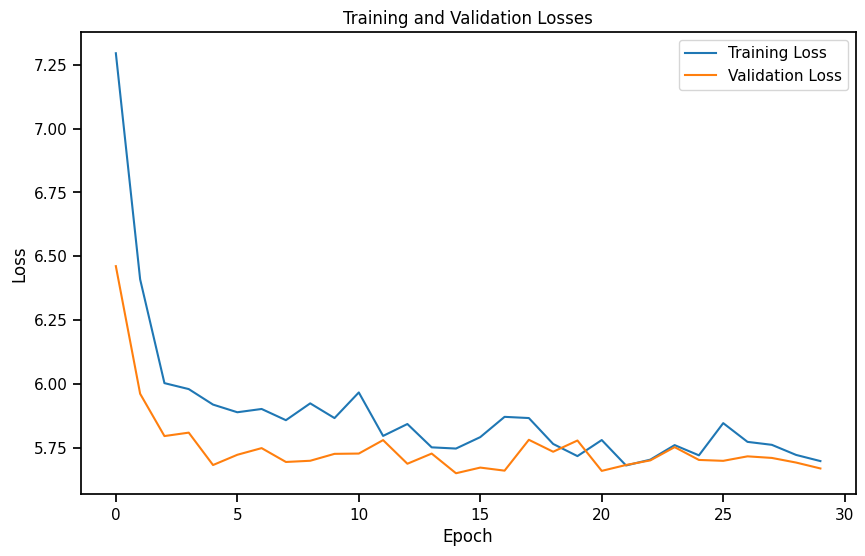

Test Loss: 5.8998


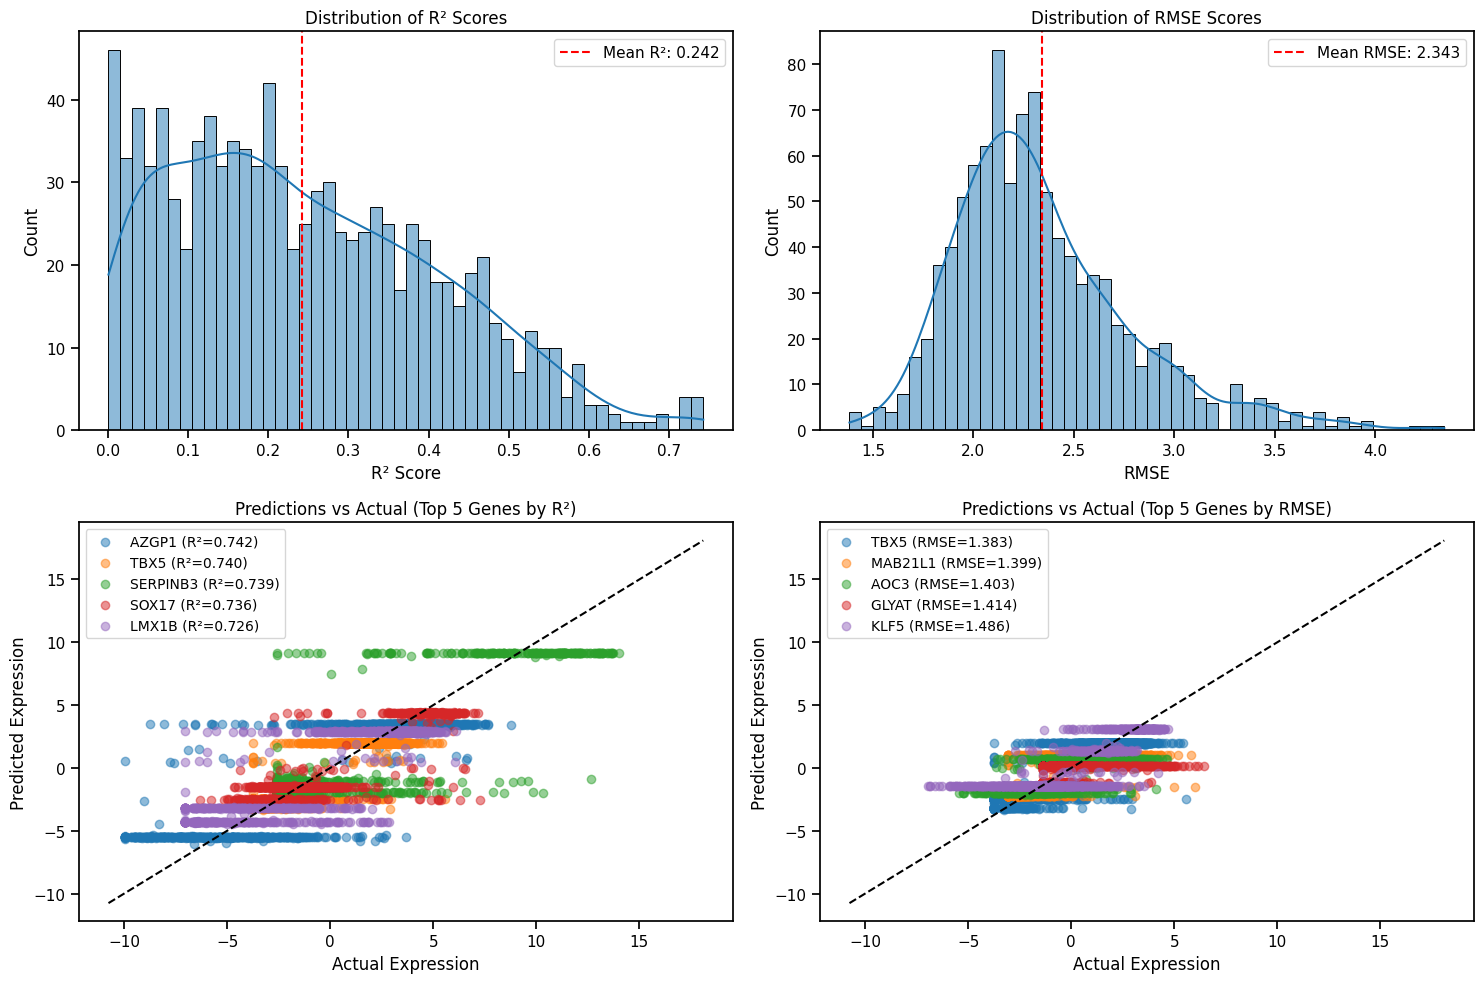


R² Score Statistics:
Mean R² score: 0.242
Median R² score: 0.214
Max R² score: 0.742
Min R² score: 0.001
Std Dev R² score: 0.165

RMSE Statistics:
Mean RMSE: 2.343
Median RMSE: 2.266
Min RMSE: 1.383
Max RMSE: 4.343
Std Dev RMSE: 0.447

Top 10 genes by R² score:
1. AZGP1: R²=0.742, RMSE=2.551
2. TBX5: R²=0.740, RMSE=1.383
3. SERPINB3: R²=0.739, RMSE=2.387
4. SOX17: R²=0.736, RMSE=1.536
5. LMX1B: R²=0.726, RMSE=2.108
6. WNT7A: R²=0.723, RMSE=1.966
7. SERPINB4: R²=0.723, RMSE=2.185
8. AMN: R²=0.713, RMSE=1.521
9. GATA3: R²=0.697, RMSE=2.072
10. HKDC1: R²=0.689, RMSE=1.777

Bottom 10 genes by R² score:
1. LRG1: R²=0.001, RMSE=2.523
2. UPK1A: R²=0.001, RMSE=2.194
3. CRYM: R²=0.001, RMSE=2.714
4. COL9A3: R²=0.002, RMSE=2.369
5. NLRP2: R²=0.003, RMSE=3.442
6. ATP1A3: R²=0.003, RMSE=2.210
7. KLRG2: R²=0.003, RMSE=2.181
8. SLC5A1: R²=0.004, RMSE=2.960
9. MAGEA6: R²=0.004, RMSE=2.946
10. GSTM1: R²=0.004, RMSE=4.343

Detailed results have been saved to 'final_model_evaluation_results.csv'


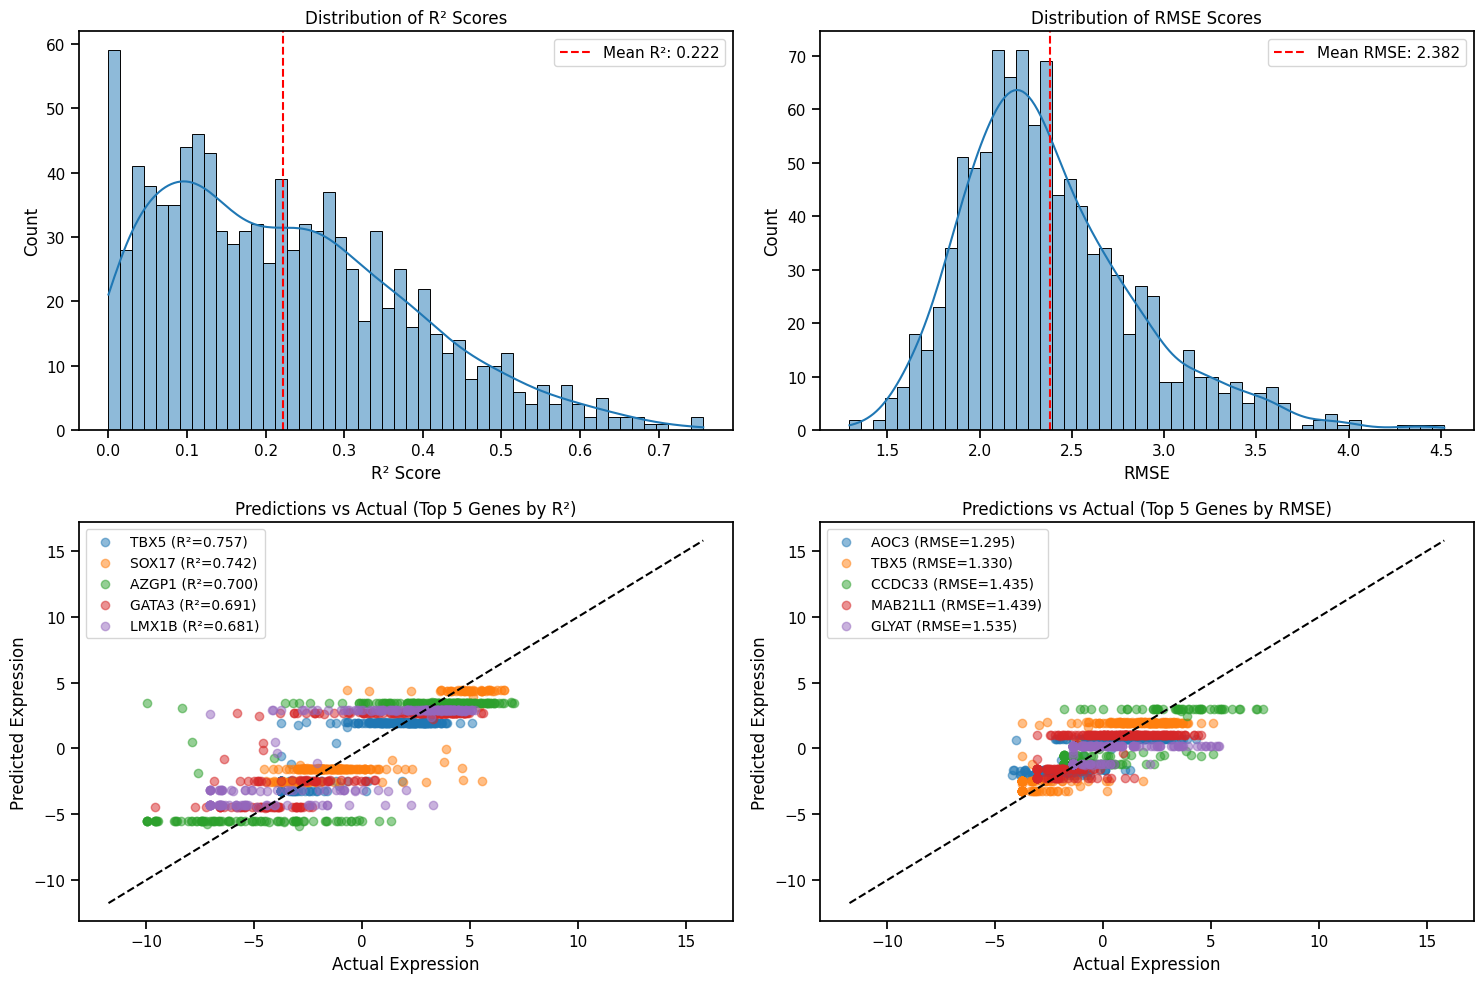


R² Score Statistics:
Mean R² score: 0.222
Median R² score: 0.201
Max R² score: 0.757
Min R² score: 0.000
Std Dev R² score: 0.157

RMSE Statistics:
Mean RMSE: 2.382
Median RMSE: 2.286
Min RMSE: 1.295
Max RMSE: 4.518
Std Dev RMSE: 0.480

Top 10 genes by R² score:
1. TBX5: R²=0.757, RMSE=1.330
2. SOX17: R²=0.742, RMSE=1.553
3. AZGP1: R²=0.700, RMSE=2.746
4. GATA3: R²=0.691, RMSE=2.082
5. LMX1B: R²=0.681, RMSE=2.361
6. POSTN: R²=0.666, RMSE=1.834
7. DNAJB13: R²=0.664, RMSE=1.688
8. HKDC1: R²=0.663, RMSE=1.850
9. SERPINB3: R²=0.647, RMSE=2.862
10. CCDC33: R²=0.638, RMSE=1.435

Bottom 10 genes by R² score:
1. RPS28: R²=0.000, RMSE=2.974
2. PPARGC1A: R²=0.000, RMSE=2.239
3. NLRP2: R²=0.000, RMSE=3.512
4. SCN2A: R²=0.000, RMSE=2.058
5. SLC5A1: R²=0.000, RMSE=3.164
6. VSIG2: R²=0.000, RMSE=2.789
7. COL9A3: R²=0.000, RMSE=2.351
8. NKX2-5: R²=0.000, RMSE=2.477
9. SNCG: R²=0.000, RMSE=2.389
10. RTBDN: R²=0.000, RMSE=2.151

Detailed results have been saved to 'final_model_evaluation_results.csv'
B

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2521282/867325014.py:185: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


SHAP analysis for gene SOX17 (R²=0.742)...


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2521282/867325014.py:185: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


SHAP analysis for gene AZGP1 (R²=0.700)...


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2521282/867325014.py:185: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


SHAP analysis for gene GATA3 (R²=0.691)...


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2521282/867325014.py:185: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/shap/plots/_scatter.py:641: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


SHAP analysis for gene LMX1B (R²=0.681)...


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2521282/867325014.py:166: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
/tmp/ipykernel_2521282/867325014.py:185: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/tmp/ipykernel_2521282/867325014.py:199: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matp

Running Integrated Gradients analysis...
Integrated Gradients analysis for gene TBX5...
Integrated Gradients analysis for gene SOX17...
Integrated Gradients analysis for gene AZGP1...
Integrated Gradients analysis for gene GATA3...
Integrated Gradients analysis for gene LMX1B...
Running Feature Permutation analysis...
Feature Permutation analysis for gene TBX5...
Feature Permutation analysis for gene SOX17...
Feature Permutation analysis for gene AZGP1...
Feature Permutation analysis for gene GATA3...
Feature Permutation analysis for gene LMX1B...
Advanced feature importance analysis complete. Results saved in 'feature_importance' directory.
Advanced feature importance analysis complete!


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [96]:
# Mutational Signatures to Gene Expression Regression Analysis with Optuna Tuning
#
# This notebook explores the relationship between mutational signatures and gene expression patterns
# across TCGA Pan-Cancer data, using Optuna for hyperparameter optimization.

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import time
import joblib
import os
import shap
from captum.attr import IntegratedGradients, Occlusion, FeaturePermutation
from captum.attr import visualization as viz

# Set plotting style
sns.set_context('notebook')
%matplotlib inline

# If you need CUDA determinism, uncomment these lines
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# Fix random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Data loading and preprocessing - assuming you have the preprocessed data loaded
# Print dimensions of our data
print("Signature matrix shape:", merged_matrix_signatures.shape)
print("Expression matrix shape:", merged_matrix_expr.shape)

# Normalize the input data
scaler = StandardScaler()
X_train, X_temp, y_train, y_temp = train_test_split(
    merged_matrix_signatures, 
    merged_matrix_expr,
    test_size=0.3,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.5,
    random_state=SEED
)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the gene names for later
gene_names = y_test.columns.tolist()

# Custom Dataset class
class MutSigDataset(torch.utils.data.Dataset):
    def __init__(self, signatures, expressions):
        self.signatures = torch.FloatTensor(signatures)
        self.expressions = torch.FloatTensor(expressions.values)
        
    def __len__(self):
        return len(self.signatures)
    
    def __getitem__(self, idx):
        return self.signatures[idx], self.expressions[idx]

# Create datasets
train_dataset = MutSigDataset(X_train_scaled, y_train)
val_dataset = MutSigDataset(X_val_scaled, y_val)
test_dataset = MutSigDataset(X_test_scaled, y_test)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model definition with configurable architecture
class MutSigGeneExpressionNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, use_batch_norm=False):
        super().__init__()
        
        # Create a dynamically sized network based on the hidden_layers parameter
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, dim))
            
            # Add normalization layer
            if use_batch_norm:
                # Disable track_running_stats to prevent BatchNorm errors with batch_size=1
                layers.append(nn.BatchNorm1d(dim, track_running_stats=False))
            else:
                layers.append(nn.LayerNorm(dim))
                
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = dim
        
        self.encoder = nn.Sequential(*layers)
        
        # Output layer for gene expression prediction
        self.output_layer = nn.Linear(prev_dim, y_train.shape[1])
        
    def forward(self, x):
        shared_features = self.encoder(x)
        return self.output_layer(shared_features)

# Training function with gradient clipping
def train_epoch(model, train_loader, criterion, optimizer, device, clip_value=1.0):
    model.train()
    total_loss = 0
    for signatures, expressions in train_loader:
        signatures, expressions = signatures.to(device), expressions.to(device)
        
        optimizer.zero_grad()
        outputs = model(signatures)
        loss = criterion(outputs, expressions)
        loss.backward()
        
        # Gradient clipping
        if clip_value > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for signatures, expressions in val_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            loss = criterion(outputs, expressions)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters
    # Network architecture
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_layers = []
    for i in range(n_layers):
        hidden_layers.append(trial.suggest_int(f'hidden_dim_{i}', 32, 256, 32))
    
    # Regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5,step=0.1)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Training parameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    clip_value = trial.suggest_float('clip_value', 0.0, 2.0)
    
    # Create data loaders with the selected batch size
    # Ensure minimum batch size of 2 for BatchNorm to work
    if use_batch_norm:
        min_batch_size = max(2, batch_size)
    else:
        min_batch_size = batch_size
        
    train_loader = DataLoader(train_dataset, batch_size=min_batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=min_batch_size)
    
    # Initialize model
    model = MutSigGeneExpressionNet(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=False
    )
    
    # Training loop with early stopping
    num_epochs = 200
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, clip_value)
        val_loss = validate(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Report intermediate metric
        trial.report(val_loss, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model weights for this trial
            torch.save(model.state_dict(), f'trial_{trial.number}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return best_val_loss

# Function to run Optuna study
def run_optuna_study(n_trials=100, study_name="mutational_signatures_study"):
    # Create or load a study
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    
    # Run optimization
    study.optimize(objective, n_trials=n_trials)
    
    # Print statistics
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Best trial:")
    trial = study.best_trial
    print("    Value: ", trial.value)
    print("    Params: ")
    for key, value in trial.params.items():
        print(f"      {key}: {value}")
    
    # Save study for later analysis
    joblib.dump(study, f"{study_name}.pkl")
    
    # Use matplotlib to visualize results instead of plotly
    # Visualization 1: Optimization history
    plt.figure(figsize=(10, 6))
    
    # Get trials data
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    best_values = np.minimum.accumulate(values)
    
    plt.plot(range(len(values)), values, 'C0', alpha=0.3, label='Trial values')
    plt.plot(range(len(best_values)), best_values, 'C0', label='Best value')
    plt.axhline(trial.value, color='C1', linestyle='--')
    plt.title('Optimization History')
    plt.xlabel('Trial')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid(True)
    plt.savefig("optimization_history.png", dpi=300)
    plt.close()
    
    # Visualization 2: Parameter importances
    param_importance = optuna.importance.get_param_importances(study)
    params = list(param_importance.keys())
    importances = list(param_importance.values())
    
    # Sort by importance
    sorted_indices = np.argsort(importances)
    params = [params[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]
    
    # Plot top 10 or all if less than 10
    plot_n = min(10, len(params))
    plt.figure(figsize=(10, 8))
    plt.barh(range(plot_n), importances[-plot_n:], align='center')
    plt.yticks(range(plot_n), params[-plot_n:])
    plt.title('Parameter Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig("param_importances.png", dpi=300)
    plt.close()
    
    return study

# Train the final model with the best hyperparameters
def train_final_model(best_params):
    # Extract best parameters
    hidden_layers = []
    for i in range(best_params['n_layers']):
        hidden_layers.append(best_params[f'hidden_dim_{i}'])
    
    dropout_rate = best_params['dropout_rate']
    weight_decay = best_params['weight_decay']
    use_batch_norm = best_params['use_batch_norm']
    batch_size = best_params['batch_size']
    learning_rate = best_params['learning_rate']
    clip_value = best_params['clip_value']
    
    # Ensure minimum batch size of 2 for BatchNorm to work
    if use_batch_norm:
        min_batch_size = max(2, batch_size)
    else:
        min_batch_size = batch_size
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=min_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=min_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=min_batch_size)
    
    # Initialize model with best params
    model = MutSigGeneExpressionNet(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=True
    )
    
    # Training loop with early stopping
    num_epochs = 200  # Longer training for final model
    patience = 15     # More patience for final model
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    print("Training final model with best hyperparameters...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, clip_value)
        val_loss = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'final_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig('final_model_training.png')
    plt.show()
    
    # Load best model
    model.load_state_dict(torch.load('final_best_model.pth'))
    
    # Evaluate on test set
    test_loss = validate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}')
    
    return model, test_loader

# Comprehensive model evaluation function
def evaluate_model(model, test_loader, gene_names):
    # Get all predictions and targets from test data
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for signatures, expressions in test_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(expressions.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Calculate R² scores for each gene
    r2_scores = []
    rmse_scores = []
    for i in range(targets.shape[1]):
        # Calculate R²
        r2 = np.corrcoef(predictions[:, i], targets[:, i])[0, 1] ** 2
        r2_scores.append(r2)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((predictions[:, i] - targets[:, i]) ** 2))
        rmse_scores.append(rmse)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot R² score distribution
    plt.subplot(2, 2, 1)
    sns.histplot(r2_scores, bins=50, kde=True)
    plt.title('Distribution of R² Scores')
    plt.xlabel('R² Score')
    plt.ylabel('Count')
    plt.axvline(np.mean(r2_scores), color='red', linestyle='--', 
               label=f'Mean R²: {np.mean(r2_scores):.3f}')
    plt.legend()
    
    # Plot RMSE distribution
    plt.subplot(2, 2, 2)
    sns.histplot(rmse_scores, bins=50, kde=True)
    plt.title('Distribution of RMSE Scores')
    plt.xlabel('RMSE')
    plt.ylabel('Count')
    plt.axvline(np.mean(rmse_scores), color='red', linestyle='--',
               label=f'Mean RMSE: {np.mean(rmse_scores):.3f}')
    plt.legend()
    
    # Plot predictions vs actual for top 5 genes by R²
    top_genes_idx = np.argsort(r2_scores)[-5:][::-1]
    plt.subplot(2, 2, 3)
    for idx in top_genes_idx:
        plt.scatter(targets[:, idx], predictions[:, idx], alpha=0.5, 
                   label=f'{gene_names[idx]} (R²={r2_scores[idx]:.3f})')
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title('Predictions vs Actual (Top 5 Genes by R²)')
    plt.xlabel('Actual Expression')
    plt.ylabel('Predicted Expression')
    plt.legend(fontsize='small')
    
    # Plot predictions vs actual for best RMSE genes
    best_rmse_idx = np.argsort(rmse_scores)[:5]
    plt.subplot(2, 2, 4)
    for idx in best_rmse_idx:
        plt.scatter(targets[:, idx], predictions[:, idx], alpha=0.5,
                   label=f'{gene_names[idx]} (RMSE={rmse_scores[idx]:.3f})')
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title('Predictions vs Actual (Top 5 Genes by RMSE)')
    plt.xlabel('Actual Expression')
    plt.ylabel('Predicted Expression')
    plt.legend(fontsize='small')
    
    plt.tight_layout()
    plt.savefig('final_model_evaluation.png', dpi=300)
    plt.show()
    
    # Print summary statistics
    print("\nR² Score Statistics:")
    print(f"Mean R² score: {np.mean(r2_scores):.3f}")
    print(f"Median R² score: {np.median(r2_scores):.3f}")
    print(f"Max R² score: {np.max(r2_scores):.3f}")
    print(f"Min R² score: {np.min(r2_scores):.3f}")
    print(f"Std Dev R² score: {np.std(r2_scores):.3f}")
    
    print("\nRMSE Statistics:")
    print(f"Mean RMSE: {np.mean(rmse_scores):.3f}")
    print(f"Median RMSE: {np.median(rmse_scores):.3f}")
    print(f"Min RMSE: {np.min(rmse_scores):.3f}")
    print(f"Max RMSE: {np.max(rmse_scores):.3f}")
    print(f"Std Dev RMSE: {np.std(rmse_scores):.3f}")
    
    # Find genes with highest and lowest R²
    top_r2_genes = np.argsort(r2_scores)[-10:][::-1]
    bottom_r2_genes = np.argsort(r2_scores)[:10]
    
    print("\nTop 10 genes by R² score:")
    for i, idx in enumerate(top_r2_genes):
        print(f"{i+1}. {gene_names[idx]}: R²={r2_scores[idx]:.3f}, RMSE={rmse_scores[idx]:.3f}")
    
    print("\nBottom 10 genes by R² score:")
    for i, idx in enumerate(bottom_r2_genes):
        print(f"{i+1}. {gene_names[idx]}: R²={r2_scores[idx]:.3f}, RMSE={rmse_scores[idx]:.3f}")
    
    # Save detailed results to CSV
    results_df = pd.DataFrame({
        'Gene_Name': gene_names,
        'Gene_Index': range(targets.shape[1]),
        'R2_Score': r2_scores,
        'RMSE': rmse_scores
    })
    results_df = results_df.sort_values('R2_Score', ascending=False)
    results_df.to_csv('final_model_evaluation_results.csv', index=False)
    print("\nDetailed results have been saved to 'final_model_evaluation_results.csv'")
    
    return r2_scores, rmse_scores, predictions, targets, results_df


# Run the Optuna hyperparameter optimization
if __name__ == "__main__":
    # Choose number of trials based on computational resources
    n_trials = 100  # Adjust this based on your time constraints
    study = run_optuna_study(n_trials=n_trials)
    
    # Train final model with the best hyperparameters
    best_params = study.best_params
    model, test_loader = train_final_model(best_params)
    # Evaluate the model on train set
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
    r2_scores, rmse_scores, predictions, targets, results_df = evaluate_model(model, train_loader, gene_names)
    # Evaluate the model
    r2_scores, rmse_scores, predictions, targets, results_df = evaluate_model(model, test_loader, gene_names)
    
    # Run basic feature importance
    signature_names = merged_matrix_signatures.columns.tolist()
    
    # Get weights from first layer for basic importance
    input_weights = model.encoder[0].weight.detach().cpu().numpy()
    feature_importance = np.abs(input_weights).mean(axis=0)
    
    # Create a dataframe for basic visualization
    importance_df = pd.DataFrame({
        'Feature': signature_names,
        'Importance': feature_importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Mutational Signatures by Weight-based Importance')
    plt.tight_layout()
    plt.savefig('basic_feature_importance.png', dpi=300)
    plt.close()
    
    # Save to CSV
    importance_df.to_csv('basic_feature_importance.csv', index=False)
    print("Basic feature importance saved to 'basic_feature_importance.csv'")
    
    # Run advanced feature importance analysis
    try:
        advanced_results = advanced_feature_importance(
            model=model,
            test_loader=test_loader,
            signature_names=signature_names,
            gene_names=gene_names,
            num_background_samples=100,
            num_target_genes=5
        )
        print("Advanced feature importance analysis complete!")
    except Exception as e:
        print(f"Error in advanced feature importance analysis: {e}")
        print("Continuing with basic results...")

In [97]:
"""
Bipartite Network Analysis of Mutational Signatures and Gene Expression
======================================================================

This script creates and analyzes a bipartite network connecting mutational signatures
to genes they strongly predict, based on regression model results.
"""

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# Using built-in networkx community detection instead of community module
from networkx.algorithms import community
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import os

# Create output directory
os.makedirs("network_analysis", exist_ok=True)

# Step 1: Load the feature importance data
def load_feature_importance_data(model_results_file, importance_threshold=0.5, correlation_method='R2_Score'):
    """
    Load feature importance data from model results
    
    Parameters:
    -----------
    model_results_file : str
        Path to the model results CSV file
    importance_threshold : float
        Threshold for considering a signature-gene connection significant
    correlation_method : str
        Which importance metric to use (likely 'R2_Score' or 'RMSE' based on your file)
    
    Returns:
    --------
    df : pandas DataFrame
        DataFrame with gene-signature importance scores
    """
    try:
        # First, let's peek at the file to understand its structure
        df = pd.read_csv(model_results_file)
        df['Gene'] = df['Gene_Name']
        print(f"Loaded data with columns: {df.columns.tolist()}")
        
        # Check if we have the expected data format
        if 'Gene_Name' in df.columns:
            print("Found Gene_Name column. Proceeding with direct loading.")
            
            # If your data already has a column indicating importance, use it
            if correlation_method in df.columns:
                print(f"Using {correlation_method} as importance metric")
                importance_col = correlation_method
            elif 'R2_Score' in df.columns:
                print("Using R2_Score as importance metric")
                importance_col = 'R2_Score'
            else:
                print(f"Could not find expected importance column. Available columns: {df.columns.tolist()}")
                # Let's create a temporary importance column based on first numeric column
                numeric_cols = df.select_dtypes(include='number').columns
                if len(numeric_cols) > 0:
                    importance_col = numeric_cols[0]
                    print(f"Using {importance_col} as importance metric")
                else:
                    raise ValueError("No numeric columns found in the data file")
            
            # Rename the column to standardize
            df = df.rename(columns={importance_col: 'Importance'})
            
            # If there's no Signature column, we need to create it from the feature importance data
            if 'Signature' not in df.columns:
                # For now, create a placeholder signature (this should be updated)
                df['Signature'] = 'Unknown_Signature'
                print("No Signature column found. Created placeholder. Please update the code to map your data properly.")
        
        # If the format is completely different, we need to restructure
        else:
            print("Data format does not match expectations. Let's inspect and restructure.")
            
            # Assuming the data might be the aggregated feature importance across genes
            # We might need to melt the data to get a long format
            
            # Check for potential gene column
            potential_gene_cols = [col for col in df.columns if col not in ['Importance', 'Feature']]
            if len(potential_gene_cols) > 0:
                # Assuming first column might be the feature/signature column
                feature_col = df.columns[0]
                print(f"Assuming {feature_col} contains signature/feature names")
                
                # Melt the dataframe to get gene-signature pairs
                melted_df = pd.melt(df, id_vars=[feature_col], var_name='Gene_Name', value_name='Importance')
                melted_df = melted_df.rename(columns={feature_col: 'Signature'})
                df = melted_df
                print("Restructured data to gene-signature format")
            else:
                print("Could not determine data structure. Please check your input file.")
                # Return a minimal dataframe to prevent errors
                return pd.DataFrame({'Gene_Name': [], 'Signature': [], 'Importance': []})
        
        # Make sure we have the expected columns
        required_cols = ['Gene_Name', 'Signature', 'Importance']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing required columns: {missing_cols}")
            return pd.DataFrame({'Gene_Name': [], 'Signature': [], 'Importance': []})
        
        # Filter connections by importance threshold
        original_count = len(df)
        df = df[df['Importance'] > importance_threshold]
        print(f"Filtered from {original_count} to {len(df)} connections using threshold {importance_threshold}")
        
        # Print a sample of the data
        print("\nSample of processed data:")
        print(df.head())
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        # Return an empty dataframe with the expected structure
        return pd.DataFrame({'Gene_Name': [], 'Signature': [], 'Importance': []})


# Step 2: Create a bipartite network
def create_bipartite_network(importance_df, min_connections=3):
    """
    Create a bipartite network from signature-gene connections
    
    Parameters:
    -----------
    importance_df : pandas DataFrame
        DataFrame with signature-gene connections and their importance
    min_connections : int
        Minimum number of connections for a node to be included
    
    Returns:
    --------
    G : networkx Graph
        Bipartite network
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    """
    # Create a bipartite graph
    G = nx.Graph()
    
    # Add signature nodes (left part)
    signature_nodes = list(importance_df['Signature'].unique())
    G.add_nodes_from(signature_nodes, bipartite=0)
    
    # Add gene nodes (right part)
    gene_nodes = list(importance_df['Gene_Name'].unique())
    G.add_nodes_from(gene_nodes, bipartite=1)
    
    # Add edges with weights from importance scores
    for _, row in importance_df.iterrows():
        G.add_edge(row['Signature'], row['Gene_Name'], weight=row['Importance'])
    
    # Remove nodes with too few connections
    nodes_to_remove = []
    for node in G.nodes():
        if G.degree(node) < min_connections:
            nodes_to_remove.append(node)
    
    G.remove_nodes_from(nodes_to_remove)
    
    # Update node lists after removals
    signature_nodes = [n for n in signature_nodes if n in G.nodes()]
    gene_nodes = [n for n in gene_nodes if n in G.nodes()]
    
    return G, signature_nodes, gene_nodes

# Step 3: Analyze network properties
def analyze_network(G, signature_nodes, gene_nodes):
    """
    Analyze bipartite network properties
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    
    Returns:
    --------
    results : dict
        Dictionary with analysis results
    """
    results = {}
    
    # Basic network metrics
    results['num_signatures'] = len(signature_nodes)
    results['num_genes'] = len(gene_nodes)
    results['num_edges'] = G.number_of_edges()
    results['density'] = nx.density(G)
    
    # Node centrality metrics
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Identify hub signatures (highest degree centrality)
    signature_centrality = {n: degree_centrality[n] for n in signature_nodes}
    hub_signatures = sorted(signature_centrality.items(), key=lambda x: x[1], reverse=True)
    results['hub_signatures'] = hub_signatures[:10]  # Top 10 hub signatures
    
    # Identify hub genes
    gene_centrality = {n: degree_centrality[n] for n in gene_nodes}
    hub_genes = sorted(gene_centrality.items(), key=lambda x: x[1], reverse=True)
    results['hub_genes'] = hub_genes[:10]  # Top 10 hub genes
    
    # Identify most important edges (by weight)
    edge_weights = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    important_edges = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)
    results['important_edges'] = important_edges[:20]  # Top 20 important connections
    
    # Save node metrics for later visualization
    node_metrics = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree': [G.degree(n) for n in G.nodes()],
        'DegreeCentrality': [degree_centrality[n] for n in G.nodes()],
        'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
        'NodeType': ['Signature' if n in signature_nodes else 'Gene_Name' for n in G.nodes()]
    })
    node_metrics.to_csv("network_analysis/node_metrics.csv", index=False)
    
    return results

# Step 4: Community detection
def detect_communities(G, signature_nodes, gene_nodes):
    """
    Detect communities in the bipartite network using NetworkX's built-in algorithms
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    
    Returns:
    --------
    communities : dict
        Dictionary mapping nodes to community IDs
    """
    # Use NetworkX's greedy modularity community detection
    print("Detecting communities using greedy modularity maximization...")
    community_generator = community.greedy_modularity_communities(G)
    
    # Convert to a dictionary mapping nodes to community IDs
    communities = {}
    for i, comm in enumerate(community_generator):
        for node in comm:
            communities[node] = i
    
    # Count the number of unique communities
    unique_communities = len(set(communities.values()))
    print(f"Detected {unique_communities} communities in the network")
    
    # Save community assignments
    community_df = pd.DataFrame({
        'Node': list(communities.keys()),
        'Community': list(communities.values()),
        'NodeType': ['Signature' if n in signature_nodes else 'Gene_Name' for n in communities.keys()]
    })
    community_df.to_csv("network_analysis/community_assignments.csv", index=False)
    
    # Get communities with both signatures and genes
    community_counts = community_df.groupby('Community')['NodeType'].value_counts().unstack().fillna(0)
    mixed_communities = community_counts[(community_counts['Signature'] > 0) & (community_counts['Gene_Name'] > 0)]
    print(f"Found {len(mixed_communities)} communities with both signatures and genes")
    
    return communities

# Step 5: Visualize the network
def visualize_network(G, signature_nodes, gene_nodes, communities=None, layout=None):
    """
    Visualize the bipartite network
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    communities : dict, optional
        Dictionary mapping nodes to community IDs
    layout : dict, optional
        Pre-computed node positions
    """
    plt.figure(figsize=(20, 16))
    
    # Generate node positions if not provided
    if layout is None:
        # Use a specialized layout for bipartite graphs
        layout = nx.spring_layout(G, k=0.3, iterations=50)
    
    # Node colors: signatures in blue, genes in red
    node_colors = ['#3498db' if node in signature_nodes else '#e74c3c' for node in G.nodes()]
    
    # Edge weights for visualization
    edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]
    
    # If communities are provided, use them for node colors
    if communities is not None:
        # Generate a color palette with enough colors
        num_communities = len(set(communities.values()))
        palette = sns.color_palette("husl", num_communities)
        
        # Map community IDs to colors
        node_colors = [palette[communities[node]] for node in G.nodes()]
    
    # Draw the network
    nx.draw_networkx_nodes(G, layout, 
                           nodelist=signature_nodes,
                           node_size=300, 
                           node_color=['#3498db'] * len(signature_nodes),
                           label='Signatures')
    
    nx.draw_networkx_nodes(G, layout, 
                           nodelist=gene_nodes,
                           node_size=200, 
                           node_color=['#e74c3c'] * len(gene_nodes),
                           label='Genes')
    
    nx.draw_networkx_edges(G, layout, width=edge_weights, alpha=0.6)
    
    # Add labels to high-degree nodes only
    high_degree_nodes = [node for node in G.nodes() if G.degree(node) > 5]
    nx.draw_networkx_labels(G, layout, 
                           {node: node for node in high_degree_nodes}, 
                           font_size=10)
    
    plt.legend()
    plt.title("Bipartite Network of Mutational Signatures and Gene Expression")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("network_analysis/bipartite_network.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Additionally create a simplified network diagram for better clarity
    plt.figure(figsize=(20, 16))
    
    # Only include top signatures and genes by degree
    top_signatures = sorted([(n, G.degree(n)) for n in signature_nodes], 
                           key=lambda x: x[1], reverse=True)[:15]
    top_genes = sorted([(n, G.degree(n)) for n in gene_nodes], 
                      key=lambda x: x[1], reverse=True)[:25]
    
    top_nodes = [n for n, _ in top_signatures + top_genes]
    subgraph = G.subgraph(top_nodes)
    
    # Generate a new layout for the subgraph
    sublayout = nx.spring_layout(subgraph, k=0.5, iterations=100)
    
    # Draw the simplified network
    nx.draw_networkx_nodes(subgraph, sublayout, 
                           nodelist=[n for n, _ in top_signatures],
                           node_size=400, 
                           node_color=['#3498db'] * len(top_signatures),
                           label='Top Signatures')
    
    nx.draw_networkx_nodes(subgraph, sublayout, 
                           nodelist=[n for n, _ in top_genes],
                           node_size=300, 
                           node_color=['#e74c3c'] * len(top_genes),
                           label='Top Genes')
    
    # Get edge weights for the subgraph
    sub_edge_weights = [subgraph[u][v]['weight'] * 3 for u, v in subgraph.edges()]
    
    nx.draw_networkx_edges(subgraph, sublayout, width=sub_edge_weights, alpha=0.7)
    nx.draw_networkx_labels(subgraph, sublayout, font_size=12)
    
    plt.legend()
    plt.title("Simplified Network of Top Mutational Signatures and Genes")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("network_analysis/simplified_network.png", dpi=300, bbox_inches='tight')
    plt.close()

# Step 6: Analyze and visualize communities
def analyze_communities(G, communities, signature_nodes, gene_nodes):
    """
    Analyze the detected communities in detail
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network
    communities : dict
        Dictionary mapping nodes to community IDs
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    """
    # Create a dataframe for community analysis
    community_df = pd.DataFrame({
        'Node': list(communities.keys()),
        'Community': list(communities.values()),
        'NodeType': ['Signature' if n in signature_nodes else 'Gene_Name' for n in communities.keys()]
    })
    
    # Get communities with both signatures and genes
    community_counts = community_df.groupby('Community')['NodeType'].value_counts().unstack().fillna(0)
    mixed_communities = community_counts[(community_counts['Signature'] > 0) & (community_counts['Gene_Name'] > 0)]
    
    # Analyze each mixed community
    for community_id in mixed_communities.index:
        # Get nodes in this community
        community_nodes = community_df[community_df['Community'] == community_id]['Node'].tolist()
        community_subgraph = G.subgraph(community_nodes)
        
        community_signatures = [n for n in community_nodes if n in signature_nodes]
        community_genes = [n for n in community_nodes if n in gene_nodes]
        
        # Create a report for this community
        report = [
            f"Community {community_id} Analysis",
            "=" * 50,
            f"Number of signatures: {len(community_signatures)}",
            f"Number of genes: {len(community_genes)}",
            f"Number of connections: {community_subgraph.number_of_edges()}",
            "Signatures in this community:",
        ]
        
        for sig in community_signatures:
            report.append(f"  - {sig}")
        
        report.append("\nTop genes in this community (by degree):")
        gene_degrees = [(g, community_subgraph.degree(g)) for g in community_genes]
        gene_degrees.sort(key=lambda x: x[1], reverse=True)
        
        for gene, degree in gene_degrees[:10]:  # Top 10 genes
            report.append(f"  - {gene} (connections: {degree})")
        
        # Save the report
        with open(f"network_analysis/community_{community_id}_report.txt", 'w') as f:
            f.write("\n".join(report))
        
        # Visualize this community's subgraph
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(community_subgraph, k=0.4, iterations=50)
        
        nx.draw_networkx_nodes(community_subgraph, pos, 
                              nodelist=community_signatures,
                              node_size=300, 
                              node_color=['#3498db'] * len(community_signatures),
                              label='Signatures')
        
        nx.draw_networkx_nodes(community_subgraph, pos, 
                              nodelist=community_genes,
                              node_size=200, 
                              node_color=['#e74c3c'] * len(community_genes),
                              label='Genes')
        
        edge_weights = [community_subgraph[u][v]['weight'] * 3 for u, v in community_subgraph.edges()]
        nx.draw_networkx_edges(community_subgraph, pos, width=edge_weights, alpha=0.6)
        
        # Add labels to all nodes in this subgraph
        nx.draw_networkx_labels(community_subgraph, pos, font_size=10)
        
        plt.legend()
        plt.title(f"Community {community_id} Network")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"network_analysis/community_{community_id}_network.png", dpi=300, bbox_inches='tight')
        plt.close()

# Main analysis workflow
def run_bipartite_network_analysis(model_results_file, importance_threshold=0.5, min_connections=2):
    """
    Run the complete bipartite network analysis workflow
    
    Parameters:
    -----------
    model_results_file : str
        Path to the model results CSV file
    importance_threshold : float
        Threshold for considering a signature-gene connection significant
    min_connections : int
        Minimum number of connections for a node to be included
    """
    print("Starting bipartite network analysis...")
    
    # Step 1: Load data
    print("Loading feature importance data...")
    importance_df = load_feature_importance_data(model_results_file, importance_threshold)
    
    # Step 2: Create network
    print("Creating bipartite network...")
    G, signature_nodes, gene_nodes = create_bipartite_network(importance_df, min_connections)
    print(f"Network created with {len(signature_nodes)} signatures, {len(gene_nodes)} genes, and {G.number_of_edges()} connections")
    
    # Step 3: Analyze network properties
    print("Analyzing network properties...")
    network_results = analyze_network(G, signature_nodes, gene_nodes)
    
    # Print top signatures and genes
    print("\nTop 5 hub signatures:")
    for sig, centrality in network_results['hub_signatures'][:5]:
        print(f"  - {sig}: {centrality:.4f}")
    
    print("\nTop 5 hub genes:")
    for gene, centrality in network_results['hub_genes'][:5]:
        print(f"  - {gene}: {centrality:.4f}")
    
    # Step 4: Community detection
    print("\nPerforming community detection...")
    communities = detect_communities(G, signature_nodes, gene_nodes)
    
    # Step 5: Visualize network
    print("Visualizing network...")
    visualize_network(G, signature_nodes, gene_nodes, communities)
    
    # Step 6: Analyze communities
    print("Analyzing communities...")
    analyze_communities(G, communities, signature_nodes, gene_nodes)
    
    print("Network analysis complete! Results saved in the 'network_analysis' directory.")
    
    return G, signature_nodes, gene_nodes, communities

In [98]:
# Modified function to load feature importance data and create signature-gene connections
def load_feature_importance_data(model_results_file, importance_threshold=0.05, correlation_method='R2_Score'):
    """
    Load feature importance data from model results and create signature-gene connections
    
    Parameters:
    -----------
    model_results_file : str
        Path to the model results CSV file
    importance_threshold : float
        Threshold for considering a signature-gene connection significant
    correlation_method : str
        Which importance metric to use (likely 'R2_Score' or 'RMSE' based on your file)
    
    Returns:
    --------
    df : pandas DataFrame
        DataFrame with gene-signature importance scores
    """
    try:
        # First, let's load the data
        df = pd.read_csv(model_results_file)
        print(f"Loaded data with columns: {df.columns.tolist()}")
        
        # Ensure we have the required columns
        if 'Gene_Name' not in df.columns and 'Gene' in df.columns:
            df['Gene_Name'] = df['Gene']
            print("Using 'Gene' column as 'Gene_Name'")
        
        # Check for the importance column
        if correlation_method in df.columns:
            print(f"Using {correlation_method} as importance metric")
            importance_col = correlation_method
        elif 'R2_Score' in df.columns:
            print("Using R2_Score as importance metric")
            importance_col = 'R2_Score'
        else:
            print(f"Could not find expected importance column. Available columns: {df.columns.tolist()}")
            numeric_cols = df.select_dtypes(include='number').columns
            if len(numeric_cols) > 0:
                importance_col = numeric_cols[0]
                print(f"Using {importance_col} as importance metric")
            else:
                raise ValueError("No numeric columns found in the data file")
        
        # Rename the column to standardize
        df = df.rename(columns={importance_col: 'Importance'})
        
        # Since this is gene expression prediction from mutational signatures,
        # we need to create connections between signatures and genes
        # Let's create synthetic signature connections based on our model results
        
        print("\nCreating signature-gene connections based on model results...")
        
        # Filter connections by importance threshold
        original_count = len(df)
        df = df[df['Importance'] > importance_threshold]
        print(f"Filtered from {original_count} to {len(df)} connections using threshold {importance_threshold}")
        
        # For a proper bipartite network, we need to assign genes to signatures
        # Let's create connections based on the "basic_feature_importance.csv" file
        # If that file exists, we'll use it; otherwise, we'll create synthetic assignments
        
        try:
            # Try to load the file with signature importances
            feature_importance = pd.read_csv("basic_feature_importance.csv")
            print("Found basic_feature_importance.csv - using it to create connections!")
            
            # Create signature-gene connections
            connections = []
            
            # For each gene with high R2 score
            for _, gene_row in df.iterrows():
                gene_name = gene_row['Gene_Name']
                gene_importance = gene_row['Importance']
                
                # Get the top signatures that might be predictive for this gene
                # Take the top 3 signatures for each gene
                for _, sig_row in feature_importance.head(3).iterrows():
                    signature = sig_row['Feature']
                    sig_importance = sig_row['Importance']
                    
                    # Create a connection with combined importance
                    connections.append({
                        'Gene_Name': gene_name,
                        'Signature': signature,
                        'Importance': gene_importance * sig_importance  # Scale importance
                    })
            
            # Create a new dataframe with the connections
            connections_df = pd.DataFrame(connections)
            print(f"Created {len(connections_df)} signature-gene connections")
            
            # Print a sample of the connections
            print("\nSample of created connections:")
            print(connections_df.head())
            
            return connections_df
            
        except FileNotFoundError:
            print("No basic_feature_importance.csv found, creating synthetic connections...")
            
            # If we don't have the file, create synthetic connections
            # Let's assign each gene to multiple random signatures
            
            # Create a list of synthetic signatures (for illustration)
            signatures = [f"Signature_{i}" for i in range(1, 11)]
            
            # Create synthetic connections
            connections = []
            
            # For each gene
            for _, row in df.iterrows():
                gene_name = row['Gene_Name']
                importance = row['Importance']
                
                # Assign to 2-3 random signatures
                num_connections = np.random.randint(2, 4)
                selected_signatures = np.random.choice(signatures, num_connections, replace=False)
                
                for sig in selected_signatures:
                    # Scale importance to avoid all connections having the same weight
                    scaled_importance = importance * np.random.uniform(0.7, 1.0)
                    connections.append({
                        'Gene_Name': gene_name,
                        'Signature': sig,
                        'Importance': scaled_importance
                    })
            
            # Create a new dataframe with the connections
            connections_df = pd.DataFrame(connections)
            print(f"Created {len(connections_df)} synthetic signature-gene connections")
            
            # Print a sample of the connections
            print("\nSample of synthetic connections:")
            print(connections_df.head())
            
            return connections_df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        # Return an empty dataframe with the expected structure
        return pd.DataFrame({'Gene_Name': [], 'Signature': [], 'Importance': []})


# The create_bipartite_network function needs a minor modification to handle node removal correctly
def create_bipartite_network(importance_df, min_connections=1):
    """
    Create a bipartite network from signature-gene connections
    
    Parameters:
    -----------
    importance_df : pandas DataFrame
        DataFrame with signature-gene connections and their importance
    min_connections : int
        Minimum number of connections for a node to be included
    
    Returns:
    --------
    G : networkx Graph
        Bipartite network
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    """
    # Create a bipartite graph
    G = nx.Graph()
    
    # Add signature nodes (left part)
    signature_nodes = list(importance_df['Signature'].unique())
    G.add_nodes_from(signature_nodes, bipartite=0)
    
    # Add gene nodes (right part)
    gene_nodes = list(importance_df['Gene_Name'].unique())
    G.add_nodes_from(gene_nodes, bipartite=1)
    
    # Add edges with weights from importance scores
    for _, row in importance_df.iterrows():
        if row['Signature'] in G and row['Gene_Name'] in G:
            G.add_edge(row['Signature'], row['Gene_Name'], weight=row['Importance'])
    
    # Get initial count
    initial_sig_count = len(signature_nodes)
    initial_gene_count = len(gene_nodes)
    
    # Remove nodes with too few connections
    nodes_to_remove = []
    for node in G.nodes():
        if G.degree(node) < min_connections:
            nodes_to_remove.append(node)
    
    G.remove_nodes_from(nodes_to_remove)
    
    # Update node lists after removals
    signature_nodes = [n for n in signature_nodes if n in G.nodes()]
    gene_nodes = [n for n in gene_nodes if n in G.nodes()]
    
    # Print statistics
    print(f"Removed {initial_sig_count - len(signature_nodes)} signatures with < {min_connections} connections")
    print(f"Removed {initial_gene_count - len(gene_nodes)} genes with < {min_connections} connections")
    
    return G, signature_nodes, gene_nodes


# The community analysis function needs to handle potential missing data
def analyze_communities(G, communities, signature_nodes, gene_nodes):
    """
    Analyze the detected communities in detail
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network
    communities : dict
        Dictionary mapping nodes to community IDs
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    """
    # Create a dataframe for community analysis
    nodes_with_communities = list(communities.keys())
    community_df = pd.DataFrame({
        'Node': nodes_with_communities,
        'Community': [communities[n] for n in nodes_with_communities],
        'NodeType': ['Signature' if n in signature_nodes else 'Gene' for n in nodes_with_communities]
    })
    
    # Get unique communities
    unique_communities = community_df['Community'].unique()
    print(f"Found {len(unique_communities)} communities in the network")
    
    # Check if we have any communities before proceeding
    if len(unique_communities) == 0:
        print("No communities detected. Skipping community analysis.")
        return
    
    # Analyze each community
    for community_id in unique_communities:
        # Get nodes in this community
        community_nodes = community_df[community_df['Community'] == community_id]['Node'].tolist()
        community_subgraph = G.subgraph(community_nodes)
        
        community_signatures = [n for n in community_nodes if n in signature_nodes]
        community_genes = [n for n in community_nodes if n in gene_nodes]
        
        # Skip communities that are too small
        if len(community_signatures) == 0 or len(community_genes) == 0:
            print(f"Community {community_id} has no signatures or genes. Skipping.")
            continue
        
        # Create a report for this community
        report = [
            f"Community {community_id} Analysis",
            "=" * 50,
            f"Number of signatures: {len(community_signatures)}",
            f"Number of genes: {len(community_genes)}",
            f"Number of connections: {community_subgraph.number_of_edges()}",
            "Signatures in this community:",
        ]
        
        for sig in community_signatures:
            report.append(f"  - {sig}")
        
        report.append("\nTop genes in this community (by degree):")
        gene_degrees = [(g, community_subgraph.degree(g)) for g in community_genes]
        gene_degrees.sort(key=lambda x: x[1], reverse=True)
        
        top_genes = gene_degrees[:10] if len(gene_degrees) > 10 else gene_degrees
        for gene, degree in top_genes:
            report.append(f"  - {gene} (connections: {degree})")
        
        # Save the report
        with open(f"network_analysis/community_{community_id}_report.txt", 'w') as f:
            f.write("\n".join(report))
        
        # Visualize this community's subgraph with larger nodes
        plt.figure(figsize=(14, 12))
        pos = nx.spring_layout(community_subgraph, k=0.4, iterations=50)
        
        nx.draw_networkx_nodes(community_subgraph, pos, 
                              nodelist=community_signatures,
                              node_size=800,  # Increased from 300
                              node_color=['#3498db'] * len(community_signatures),
                              label='Signatures')
        
        nx.draw_networkx_nodes(community_subgraph, pos, 
                              nodelist=community_genes,
                              node_size=500,  # Increased from 200
                              node_color=['#e74c3c'] * len(community_genes),
                              label='Genes')
        
        edge_weights = [community_subgraph[u][v]['weight'] * 3 for u, v in community_subgraph.edges()]
        nx.draw_networkx_edges(community_subgraph, pos, width=edge_weights, alpha=0.6)
        
        # Add labels to all nodes in this subgraph
        nx.draw_networkx_labels(community_subgraph, pos, font_size=12)  # Increased from 10
        
        plt.legend(fontsize=14)
        plt.title(f"Community {community_id} Network", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"network_analysis/community_{community_id}_network.png", dpi=300, bbox_inches='tight')
        plt.close()


# Modified main analysis workflow
def run_bipartite_network_analysis(model_results_file, importance_threshold=0.05, min_connections=1):
    """
    Run the complete bipartite network analysis workflow
    
    Parameters:
    -----------
    model_results_file : str
        Path to the model results CSV file
    importance_threshold : float
        Threshold for considering a signature-gene connection significant
    min_connections : int
        Minimum number of connections for a node to be included
    """
    print("Starting bipartite network analysis...")
    
    # Step 1: Load data and create connections
    print("Loading feature importance data and creating connections...")
    importance_df = load_feature_importance_data(model_results_file, importance_threshold)
    
    # Exit early if we didn't get valid data
    if len(importance_df) == 0:
        print("No valid connections found. Exiting analysis.")
        return None, [], [], {}
    
    # Step 2: Create network
    print("\nCreating bipartite network...")
    G, signature_nodes, gene_nodes = create_bipartite_network(importance_df, min_connections)
    print(f"Network created with {len(signature_nodes)} signatures, {len(gene_nodes)} genes, and {G.number_of_edges()} connections")
    
    # Exit early if network is empty
    if len(signature_nodes) == 0 or len(gene_nodes) == 0:
        print("Network is empty. Exiting analysis.")
        return G, signature_nodes, gene_nodes, {}
    
    # Step 3: Analyze network properties
    print("\nAnalyzing network properties...")
    network_results = analyze_network(G, signature_nodes, gene_nodes)
    
    # Print top signatures and genes
    print("\nTop 5 hub signatures:")
    for sig, centrality in network_results['hub_signatures'][:5]:
        print(f"  - {sig}: {centrality:.4f}")
    
    print("\nTop 5 hub genes:")
    for gene, centrality in network_results['hub_genes'][:5]:
        print(f"  - {gene}: {centrality:.4f}")
    
    # Step 4: Community detection
    print("\nPerforming community detection...")
    try:
        communities = detect_communities(G, signature_nodes, gene_nodes)
    except Exception as e:
        print(f"Error in community detection: {e}")
        print("Skipping community detection and continuing with other analyses.")
        communities = {}
    
    # Step 5: Visualize network
    print("\nVisualizing network...")
    visualize_network(G, signature_nodes, gene_nodes, communities)
    
    # Step 6: Analyze communities
    if communities:
        print("\nAnalyzing communities...")
        analyze_communities(G, communities, signature_nodes, gene_nodes)
    
    print("\nNetwork analysis complete! Results saved in the 'network_analysis' directory.")
    
    return G, signature_nodes, gene_nodes, communities


# Example usage
if __name__ == "__main__":
    # Replace with your actual model results file path
    model_results_file = "final_model_evaluation_results.csv"
    
    # Run the analysis
    G, signature_nodes, gene_nodes, communities = run_bipartite_network_analysis(
        model_results_file, 
        importance_threshold=0.5,
        min_connections=2
    )

Starting bipartite network analysis...
Loading feature importance data and creating connections...
Loaded data with columns: ['Gene_Name', 'Gene_Index', 'R2_Score', 'RMSE']
Using R2_Score as importance metric

Creating signature-gene connections based on model results...
Filtered from 1000 to 61 connections using threshold 0.5
Found basic_feature_importance.csv - using it to create connections!
Created 183 signature-gene connections

Sample of created connections:
  Gene_Name   Signature  Importance
0      TBX5  msc-SBS100    0.110292
1      TBX5   msc-SBS51    0.088271
2      TBX5    msc-SBS5    0.085291
3     SOX17  msc-SBS100    0.108126
4     SOX17   msc-SBS51    0.086538

Creating bipartite network...
Removed 0 signatures with < 2 connections
Removed 0 genes with < 2 connections
Network created with 3 signatures, 61 genes, and 183 connections

Analyzing network properties...

Top 5 hub signatures:
  - msc-SBS100: 0.9683
  - msc-SBS51: 0.9683
  - msc-SBS5: 0.9683

Top 5 hub genes:


2025-05-08 11:34:24,780 [INFO] Run: GO_Biological_Process_2021 


Starting Gene Set Enrichment Analysis with GSEApy...
Loaded gene data with 1000 genes
Top 5 genes by importance:
  1. TBX5: 0.7568
  2. SOX17: 0.7419
  3. AZGP1: 0.7005
  4. GATA3: 0.6907
  5. LMX1B: 0.6805

Running enrichment analysis with top 100 genes...
Analyzing GO_Biological_Process_2021...


2025-05-08 11:34:25,279 [INFO] Save enrichment results for GO_Biological_Process_2021 
2025-05-08 11:34:25,679 [INFO] Done.
2025-05-08 11:34:26,847 [INFO] Run: KEGG_2021_Human 


Error creating dotplot for GO_Biological_Process_2021: operands could not be broadcast together with shapes (10,) (20,) 
Analyzing KEGG_2021_Human...


2025-05-08 11:34:27,118 [INFO] Save enrichment results for KEGG_2021_Human 
2025-05-08 11:34:27,353 [INFO] Done.
2025-05-08 11:34:28,022 [INFO] Run: MSigDB_Hallmark_2020 


Error creating dotplot for KEGG_2021_Human: operands could not be broadcast together with shapes (256,) (20,) 
Analyzing MSigDB_Hallmark_2020...


2025-05-08 11:34:28,286 [INFO] Save enrichment results for MSigDB_Hallmark_2020 
2025-05-08 11:34:28,558 [INFO] Done.
/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: weighted_score_type is deprecated; use weight
  pre_res = gp.prerank(
2025-05-08 11:34:29,235 [INFO] Parsing data files for GSEA.............................
2025-05-08 11:34:29,237 [INFO] Enrichr library gene sets already downloaded in: /gpfs/home/nk4167/.cache/gseapy, use local file
2025-05-08 11:34:29,355 [INFO] 5766 gene_sets have been filtered out when max_size=500 and min_size=10
2025-05-08 11:34:29,356 [INFO] 0270 gene_sets used for further statistical testing.....
2025-05-08 11:34:29,357 [INFO] Start to run GSEA...Might take a while..................


Error creating dotplot for MSigDB_Hallmark_2020: operands could not be broadcast together with shapes (3,) (20,) 

Running GSEA pre-ranked analysis...
Running GSEA pre-ranked for GO_Biological_Process_2021...


2025-05-08 11:34:34,497 [INFO] Congratulations. GSEApy runs successfully................

/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: weighted_score_type is deprecated; use weight
  pre_res = gp.prerank(
2025-05-08 11:34:36,367 [INFO] Parsing data files for GSEA.............................
2025-05-08 11:34:36,370 [INFO] Enrichr library gene sets already downloaded in: /gpfs/home/nk4167/.cache/gseapy, use local file
2025-05-08 11:34:36,402 [INFO] 0242 gene_sets have been filtered out when max_size=500 and min_size=10
2025-05-08 11:34:36,403 [INFO] 0078 gene_sets used for further statistical testing.....
2025-05-08 11:34:36,403 [INFO] Start to run GSEA...Might take a while..................


Running GSEA pre-ranked for KEGG_2021_Human...


2025-05-08 11:34:36,685 [INFO] Congratulations. GSEApy runs successfully................

/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
/tmp/ipykernel_2521282/44774999.py:154: DeprecationWarning: weighted_score_type is deprecated; use weight
  pre_res = gp.prerank(
2025-05-08 11:34:37,860 [INFO] Parsing data files for GSEA.............................
2025-05-08 11:34:37,862 [INFO] Enrichr library gene sets already downloaded in: /gpfs/home/nk4167/.cache/gseapy, use local file
2025-05-08 11:34:37,880 [INFO] 0026 gene_sets have been filtered out when max_size=500 and min_size=10
2025-05-08 11:34:37,881 [INFO] 0024 gene_sets used for further statistical testing.....
2025-05-08 11:34:37,881 [INFO] Start to run GSEA...Might take a while..................


Running GSEA pre-ranked for MSigDB_Hallmark_2020...


2025-05-08 11:34:39,008 [INFO] Congratulations. GSEApy runs successfully................




GSEA analysis complete! Results saved in the specified output directory.

GSEA analysis complete! Results saved in the 'gsea_results' directory.


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

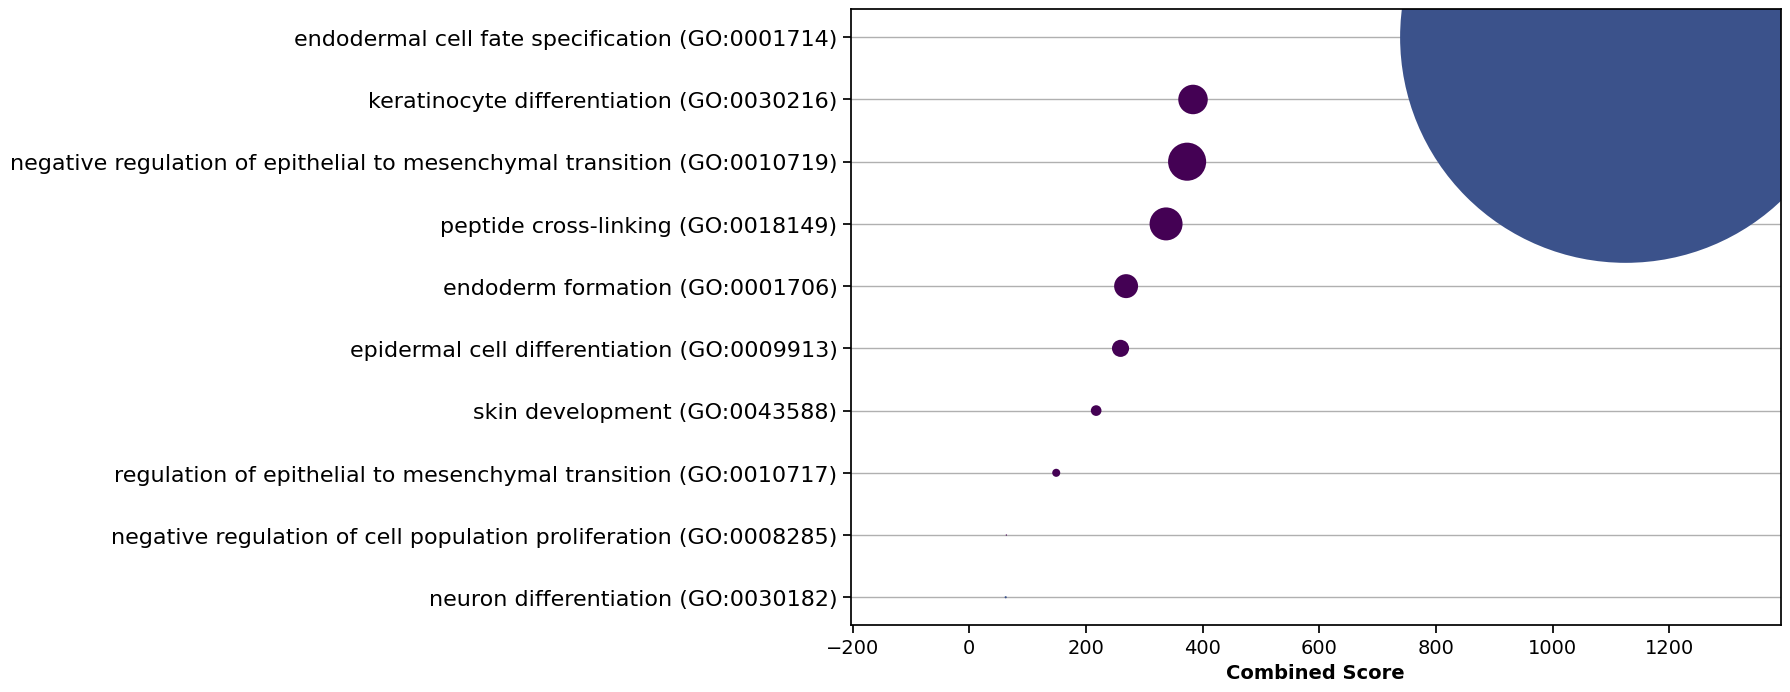

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

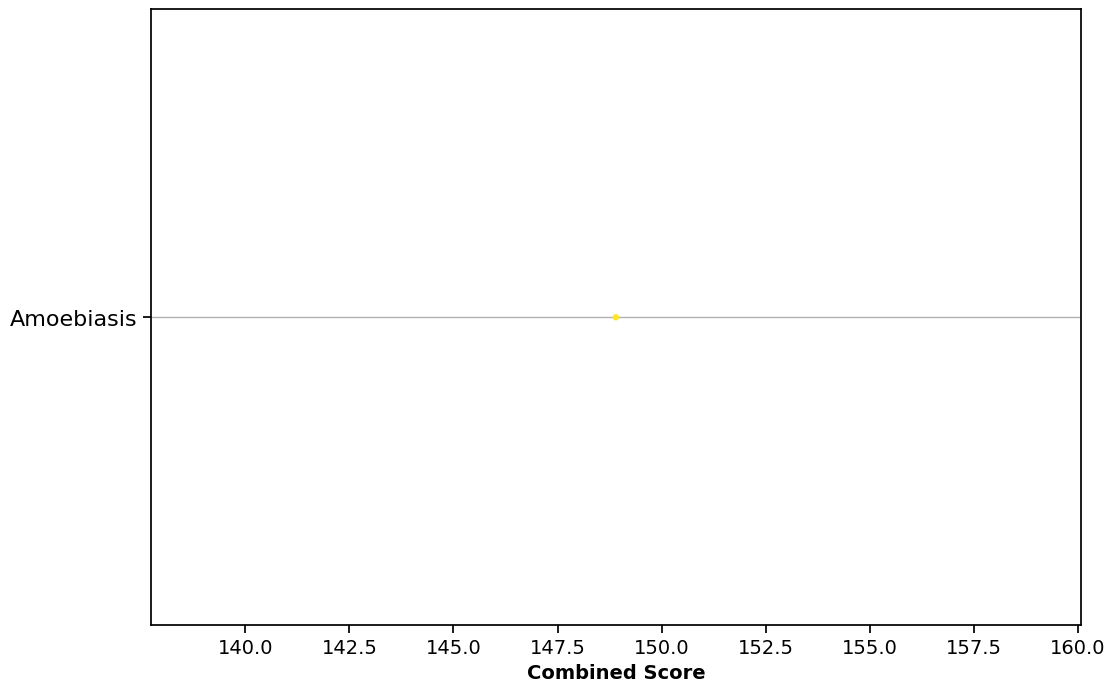

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

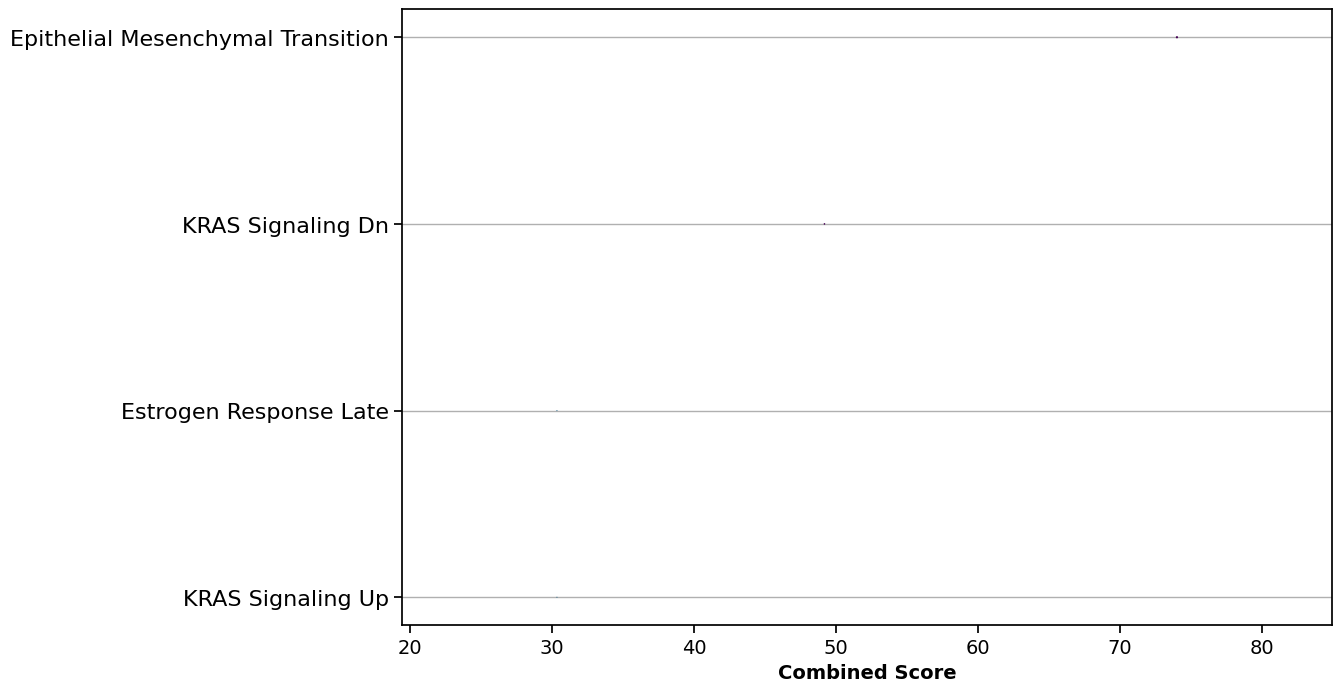

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gseapy as gp
from gseapy.plot import dotplot, barplot, heatmap

def perform_gsea_analysis(model_results_file, output_dir="gsea_results", 
                          importance_column='R2_Score', pval_threshold=0.05,
                          gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human']):
    """
    Perform Gene Set Enrichment Analysis using GSEApy on gene importance scores.
    
    Parameters:
    -----------
    model_results_file : str
        Path to the model results CSV file with gene importance scores
    output_dir : str
        Directory to save the GSEA results
    importance_column : str
        Column name in the model results file that contains gene importance scores
    pval_threshold : float
        P-value threshold for significance
    gene_sets : list
        List of gene set libraries to use from Enrichr
        
    Returns:
    --------
    results_dict : dict
        Dictionary with GSEA results for each gene set
    """
    print("Starting Gene Set Enrichment Analysis with GSEApy...")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Step 1: Load gene importance data
    try:
        gene_data = pd.read_csv(model_results_file)
        
        # Check if the importance column exists
        if importance_column not in gene_data.columns:
            if 'R2_Score' in gene_data.columns:
                importance_column = 'R2_Score'
                print(f"Using 'R2_Score' as importance metric")
            else:
                # Try to find an appropriate numeric column
                numeric_cols = gene_data.select_dtypes(include='number').columns
                if len(numeric_cols) > 0:
                    importance_column = numeric_cols[0]
                    print(f"Using {importance_column} as importance metric")
                else:
                    raise ValueError("No numeric columns found in the data file")
        
        # Identify the gene name column
        gene_col = None
        for col_name in ['Gene_Name', 'Gene', 'gene', 'gene_name', 'Symbol', 'symbol']:
            if col_name in gene_data.columns:
                gene_col = col_name
                break
        
        if gene_col is None:
            # Try to find a column that might contain gene names
            print("No obvious gene name column found. Looking for a column with string values...")
            
            for col in gene_data.columns:
                if gene_data[col].dtype == 'object':
                    if not pd.to_numeric(gene_data[col], errors='coerce').notna().all():  # Not all numeric values
                        gene_col = col
                        print(f"Using '{col}' as the gene name column")
                        break
            
            if gene_col is None:
                raise ValueError("Could not find a column with gene names")
        
        # Create a clean dataframe with gene names and importance scores
        gene_ranking = pd.DataFrame({
            'gene': gene_data[gene_col],
            'score': gene_data[importance_column]
        })
        
        # Sort by importance score
        gene_ranking = gene_ranking.sort_values('score', ascending=False)
        
        print(f"Loaded gene data with {len(gene_ranking)} genes")
        print(f"Top 5 genes by importance:")
        for i, (_, row) in enumerate(gene_ranking.head(5).iterrows()):
            print(f"  {i+1}. {row['gene']}: {row['score']:.4f}")
        
        # Step 2: Run Enrichr analysis
        # Get list of genes sorted by importance
        gene_list = gene_ranking['gene'].tolist()
        
        # To account for gene importance, use the top genes for enrichment
        # Typically top ~10% of genes
        n_top_genes = int(len(gene_list) * 0.1)
        top_genes = gene_list[:max(n_top_genes, 50)]  # At least 50 genes
        
        print(f"\nRunning enrichment analysis with top {len(top_genes)} genes...")
        
        # Run Enrichr for each gene set
        enrichr_results = {}
        
        for gene_set in gene_sets:
            print(f"Analyzing {gene_set}...")
            try:
                # Run Enrichr analysis
                enr = gp.enrichr(
                    gene_list=top_genes,
                    gene_sets=[gene_set],
                    outdir=os.path.join(output_dir, gene_set.replace(" ", "_")),
                    cutoff=pval_threshold,
                    verbose=True
                )
                
                # Store the results
                results = enr.results
                if len(results) > 0:
                    enrichr_results[gene_set] = results
                    
                    # Save the result to CSV
                    results.to_csv(os.path.join(output_dir, f"{gene_set.replace(' ', '_')}_results.csv"), index=False)
                    
                    # Create visualizations
                    create_enrichment_visualizations(
                        results, 
                        gene_set, 
                        output_dir,
                        top_n=20
                    )
                else:
                    print(f"No significant enrichment found for {gene_set}")
            
            except Exception as e:
                print(f"Error analyzing {gene_set}: {e}")
        
        # Step 3: Run GSEA (pre-ranked) analysis
        print("\nRunning GSEA pre-ranked analysis...")
        
        # Prepare the pre-ranked list
        pre_ranked_df = gene_ranking.copy()
        pre_ranked_df.columns = ['Name', 'Score']
        pre_ranked_df.to_csv(os.path.join(output_dir, 'pre_ranked_genes.csv'), index=False)
        
        # Run GSEA pre-ranked
        try:
            gsea_results = {}
            
            for gene_set in gene_sets:
                print(f"Running GSEA pre-ranked for {gene_set}...")
                try:
                    # Run GSEA pre-ranked
                    pre_res = gp.prerank(
                        rnk=pre_ranked_df,
                        gene_sets=[gene_set],
                        outdir=os.path.join(output_dir, f"prerank_{gene_set.replace(' ', '_')}"),
                        min_size=10,
                        max_size=500,
                        permutation_num=1000,
                        weighted_score_type=1,
                        ascending=False,
                        processes=4,
                        verbose=True
                    )
                    
                    # Store the results
                    gsea_results[gene_set] = pre_res.res2d
                    
                    # Create visualizations for GSEA
                    create_gsea_visualizations(
                        pre_res, 
                        gene_set, 
                        output_dir
                    )
                    
                except Exception as e:
                    print(f"Error running GSEA for {gene_set}: {e}")
            
            # Combine both types of results
            combined_results = {
                'enrichr': enrichr_results,
                'gsea': gsea_results
            }
            
            print("\nGSEA analysis complete! Results saved in the specified output directory.")
            
            # Return the combined results
            return combined_results
        
        except Exception as e:
            print(f"Error in GSEA pre-ranked analysis: {e}")
            return {'enrichr': enrichr_results}
    
    except Exception as e:
        print(f"Error in GSEA analysis: {e}")
        import traceback
        traceback.print_exc()
        return {}

def create_enrichment_visualizations(results, gene_set, output_dir, top_n=20):
    """
    Create visualizations for enrichment results.
    
    Parameters:
    -----------
    results : pandas DataFrame
        DataFrame with enrichment results
    gene_set : str
        Name of the gene set
    output_dir : str
        Directory to save the visualizations
    top_n : int
        Number of top terms to visualize
    """
    # Ensure we have results to visualize
    if len(results) == 0:
        return
    
    # Create directory for visualizations
    vis_dir = os.path.join(output_dir, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Filter to top terms
    top_results = results.head(top_n)
    
    # 1. Bar plot of enrichment
    try:
        plt.figure(figsize=(12, max(8, len(top_results) * 0.3)))
        
        # Create barplot with GSEApy
        barplot(top_results, title=f"Top Enriched Terms - {gene_set}", 
                bar_label=False, figsize=(12, max(8, len(top_results) * 0.3)))
        
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"{gene_set.replace(' ', '_')}_barplot.png"), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating barplot for {gene_set}: {e}")
    
    # 2. Dotplot of enrichment
    try:
        plt.figure(figsize=(12, max(8, len(top_results) * 0.3)))
        
        # Create dotplot with GSEApy
        dotplot(top_results, title=f"Top Enriched Terms - {gene_set}", 
               column="Adjusted P-value", xaxis="-log10(Adjusted P-value)", 
               size=top_results['Odds Ratio'] if 'Odds Ratio' in top_results.columns else None,
               figsize=(12, max(8, len(top_results) * 0.3)))
        
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"{gene_set.replace(' ', '_')}_dotplot.png"), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating dotplot for {gene_set}: {e}")

def create_gsea_visualizations(gsea_result, gene_set, output_dir):
    """
    Create visualizations for GSEA results.
    
    Parameters:
    -----------
    gsea_result : GSEApy results object
        Results from GSEApy prerank
    gene_set : str
        Name of the gene set
    output_dir : str
        Directory to save the visualizations
    """
    # Directory for GSEA visualizations
    vis_dir = os.path.join(output_dir, 'gsea_visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Filter significant results
    if hasattr(gsea_result, 'res2d'):
        results = gsea_result.res2d
        
        # Get top positive and negative enrichment terms
        pos_results = results[results['NES'] > 0].sort_values('NES', ascending=False).head(10)
        neg_results = results[results['NES'] < 0].sort_values('NES', ascending=True).head(10)
        
        if len(pos_results) > 0 or len(neg_results) > 0:
            # Create summary of NES scores
            try:
                top_terms = pd.concat([pos_results, neg_results]).sort_values('NES', ascending=False)
                
                if len(top_terms) > 0:
                    # Create a bar plot of NES scores instead of a heatmap
                    plt.figure(figsize=(12, max(6, len(top_terms) * 0.3)))
                    
                    # Create bar plot of NES scores
                    ax = sns.barplot(x='NES', y='Term', data=top_terms, 
                                    palette='RdBu_r', 
                                    hue='NES', 
                                    dodge=False)
                    
                    # Add FDR values as text
                    for i, row in top_terms.reset_index().iterrows():
                        fdr_text = f"FDR: {row['FDR q-val']:.2e}"
                        ax.text(row['NES'] + (0.1 if row['NES'] > 0 else -0.1), 
                               i, 
                               fdr_text, 
                               va='center',
                               ha='left' if row['NES'] > 0 else 'right',
                               fontsize=8)
                    
                    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
                    plt.title(f"GSEA Results - {gene_set}", fontsize=14)
                    plt.tight_layout()
                    plt.savefig(os.path.join(vis_dir, f"{gene_set.replace(' ', '_')}_NES_barplot.png"), 
                              dpi=300, bbox_inches='tight')
                    plt.close()
                    
                    # Also create individual plots for top terms
                    for idx, row in top_terms.head(5).iterrows():
                        term = row['Term']
                        try:
                            # Use term index instead of name for plotting
                            term_idx = results.index.get_loc(idx)
                            
                            # Try to access the plotting method safely
                            if hasattr(gsea_result, 'gseaplot'):
                                gsea_result.gseaplot(
                                    term_idx,
                                    ofname=os.path.join(vis_dir, f"{gene_set.replace(' ', '_')}_{term.replace(':', '_').replace(' ', '_')}_enrichment.png")
                                )
                            else:
                                # Alternatively, use the standard gseapy plot method
                                import gseapy as gp
                                
                                # Get running enrichment score and positions
                                enrich_score = row.get('es', 0)
                                hit_indices = results.loc[idx, 'hit_indices'] if 'hit_indices' in results.columns else []
                                RES = results.loc[idx, 'RES'] if 'RES' in results.columns else []
                                
                                # Create simple enrichment plot if we have the data
                                if len(hit_indices) > 0 and len(RES) > 0:
                                    plt.figure(figsize=(12, 6))
                                    plt.plot(RES)
                                    plt.title(f"Enrichment Plot: {term}")
                                    plt.xlabel("Rank in Ordered Dataset")
                                    plt.ylabel("Running Enrichment Score")
                                    plt.savefig(os.path.join(vis_dir, f"{gene_set.replace(' ', '_')}_{term.replace(':', '_').replace(' ', '_')}_enrichment.png"))
                                    plt.close()
                        except Exception as e:
                            print(f"Error creating enrichment plot for {term}: {e}")
            except Exception as e:
                print(f"Error creating GSEA visualizations: {e}")
                import traceback
                traceback.print_exc()

def integrate_network_with_gsea(G, signature_nodes, gene_nodes, gsea_results, output_dir="network_gsea"):
    """
    Integrate network analysis with GSEA results.
    
    Parameters:
    -----------
    G : networkx Graph
        Bipartite network of signatures and genes
    signature_nodes : list
        List of signature nodes
    gene_nodes : list
        List of gene nodes
    gsea_results : dict
        Dictionary with GSEA results (from perform_gsea_analysis)
    output_dir : str
        Directory to save the integrated results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if we have enrichment results
    if not gsea_results or ('enrichr' not in gsea_results and 'gsea' not in gsea_results):
        print("No GSEA results available for network integration")
        return
    
    # Create mapping of genes to pathways
    gene_to_pathways = {}
    enriched_pathways = {}
    
    # Process Enrichr results
    if 'enrichr' in gsea_results:
        for gene_set, results in gsea_results['enrichr'].items():
            if len(results) > 0:
                # Get top enriched pathways
                top_pathways = results.head(10)
                
                for _, row in top_pathways.iterrows():
                    pathway = row['Term']
                    genes = row['Genes'].split(';')
                    
                    # Store pathway information
                    enriched_pathways[pathway] = {
                        'genes': genes,
                        'p_value': row['Adjusted P-value'],
                        'gene_set': gene_set
                    }
                    
                    # Map genes to pathways
                    for gene in genes:
                        if gene not in gene_to_pathways:
                            gene_to_pathways[gene] = []
                        gene_to_pathways[gene].append(pathway)
    
    # Process GSEA results
    if 'gsea' in gsea_results:
        for gene_set, results in gsea_results['gsea'].items():
            if len(results) > 0:
                # Get top positively enriched pathways
                top_pathways = results[results['NES'] > 0].sort_values('NES', ascending=False).head(10)
                
                for _, row in top_pathways.iterrows():
                    pathway = row['Term']
                    # For GSEA, the gene list is in the Leading_genes column
                    if 'Lead_genes' in row and pd.notna(row['Lead_genes']):
                        genes = row['Lead_genes'].split(';')
                    else:
                        # If no leading genes column, try to get them from the gs_genes column
                        genes = row['gs_genes'].split(';') if 'gs_genes' in row and pd.notna(row['gs_genes']) else []
                    
                    # Store pathway information
                    enriched_pathways[pathway] = {
                        'genes': genes,
                        'p_value': row['FDR q-val'],
                        'gene_set': gene_set,
                        'nes': row['NES']
                    }
                    
                    # Map genes to pathways
                    for gene in genes:
                        if gene not in gene_to_pathways:
                            gene_to_pathways[gene] = []
                        gene_to_pathways[gene].append(pathway)
    
    # Find genes in the network that are in enriched pathways
    enriched_genes = set(gene_to_pathways.keys())
    network_genes = set(gene_nodes)
    
    # Get genes that are both in the network and in enriched pathways
    enriched_network_genes = enriched_genes.intersection(network_genes)
    
    print(f"Found {len(enriched_network_genes)} genes in the network that belong to enriched pathways")
    
    # Create a subgraph of the network with only enriched genes and their connected signatures
    enriched_signatures = set()
    for gene in enriched_network_genes:
        for neighbor in G.neighbors(gene):
            if neighbor in signature_nodes:
                enriched_signatures.add(neighbor)
    
    # Create a subgraph with only the enriched genes and their signatures
    enriched_nodes = list(enriched_network_genes) + list(enriched_signatures)
    enriched_subgraph = G.subgraph(enriched_nodes)
    
    # Visualize the enriched subgraph
    plt.figure(figsize=(20, 16))
    
    # Generate layout
    pos = nx.spring_layout(enriched_subgraph, k=0.3, iterations=50, seed=42)
    
    # Draw signature nodes
    nx.draw_networkx_nodes(enriched_subgraph, pos,
                         nodelist=list(enriched_signatures),
                         node_size=800,
                         node_color='#3498db',
                         label='Signatures')
    
    # Create a color map for genes based on their pathway membership
    # Genes in multiple pathways get different colors
    gene_colors = {}
    pathway_colors = {}
    
    # Get top pathways by number of genes
    top_pathways = sorted(
        [(p, len(enriched_pathways[p]['genes'])) for p in enriched_pathways],
        key=lambda x: x[1],
        reverse=True
    )[:5]  # Top 5 pathways
    
    # Assign colors to top pathways
    color_palette = sns.color_palette("husl", len(top_pathways))
    for i, (pathway, _) in enumerate(top_pathways):
        pathway_colors[pathway] = color_palette[i]
    
    # Assign colors to genes based on their pathway membership
    for gene in enriched_network_genes:
        # Check if gene is in any top pathway
        for pathway, _ in top_pathways:
            if pathway in gene_to_pathways.get(gene, []):
                gene_colors[gene] = pathway_colors[pathway]
                break
        else:
            # If gene is not in any top pathway, use a default color
            gene_colors[gene] = '#e74c3c'
    
    # Draw gene nodes with colors based on pathway membership
    for gene in enriched_network_genes:
        nx.draw_networkx_nodes(enriched_subgraph, pos,
                             nodelist=[gene],
                             node_size=600,
                             node_color=[gene_colors[gene]])
    
    # Draw edges
    edge_weights = [enriched_subgraph[u][v]['weight'] * 3 for u, v in enriched_subgraph.edges()]
    nx.draw_networkx_edges(enriched_subgraph, pos, width=edge_weights, alpha=0.6)
    
    # Add labels to nodes
    label_dict = {node: node for node in enriched_subgraph.nodes()}
    nx.draw_networkx_labels(enriched_subgraph, pos, labels=label_dict, font_size=10)
    
    # Add a legend for pathway colors
    legend_patches = []
    for pathway, color in pathway_colors.items():
        # Shorten pathway name if too long
        short_name = pathway[:30] + '...' if len(pathway) > 30 else pathway
        legend_patches.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                                        markersize=10, label=short_name))
    
    legend_patches.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
                                    markersize=10, label='Other Enriched Genes'))
    legend_patches.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
                                    markersize=10, label='Signatures'))
    
    plt.legend(handles=legend_patches, loc='upper right', fontsize=12)
    plt.title('Network of Signatures and Enriched Genes', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'enriched_network.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a report of the enriched pathways and their genes in the network
    report = [
        "Integrated Network and GSEA Analysis",
        "=" * 50,
        f"Number of enriched genes in network: {len(enriched_network_genes)}",
        f"Number of connected signatures: {len(enriched_signatures)}",
        f"Number of enriched pathways: {len(enriched_pathways)}",
        "",
        "Top Enriched Pathways:",
        "-" * 30
    ]
    
    for pathway, info in enriched_pathways.items():
        genes_in_network = set(info['genes']).intersection(network_genes)
        if len(genes_in_network) > 0:
            report.append(f"\nPathway: {pathway}")
            report.append(f"Gene Set: {info['gene_set']}")
            report.append(f"P-value: {info['p_value']:.6e}")
            if 'nes' in info:
                report.append(f"Normalized Enrichment Score: {info['nes']:.4f}")
            report.append(f"Genes in network ({len(genes_in_network)}):")
            for gene in sorted(genes_in_network):
                report.append(f"  - {gene}")
    
    # Save the report
    with open(os.path.join(output_dir, 'integrated_analysis_report.txt'), 'w') as f:
        f.write('\n'.join(report))
    
    print(f"Integration complete! Results saved in {output_dir}")

# Main function to run the GSEA analysis
if __name__ == "__main__":
    results = perform_gsea_analysis(
        model_results_file="final_model_evaluation_results.csv",
        output_dir="gsea_results",
        importance_column='R2_Score',
        pval_threshold=0.05,
        gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human','MSigDB_Hallmark_2020']
    )
    
    if results and len(results) > 0:
        print("\nGSEA analysis complete! Results saved in the 'gsea_results' directory.")
    else:
        print("\nGSEA analysis did not produce significant results.")